# ML — SVR Modeling (Clean Data Template)


Purpose
-------
Prepare cleaned, model-ready car-pricing data and evaluate Support Vector Regression baselines using the project's preprocessing utilities and feature-selection procedures.



Datasets used
--------------
- `Data/train.csv` — labeled training data
- `Data/test.csv` — unlabeled test data (used for final submission workflows)
- External vehicle models (downloaded from Kaggle: `vehicle models.json`)



Expected outputs
----------------
- A fitted `DataPreprocessor` instance for reproducible transforms
- A concise selected feature list (from feature-selection steps)
- Trained baseline models (SVR and optionally others) and saved model artifacts (pickle/joblib)
- Evaluation metrics: RMSE, MAE, R² (table)
- Diagnostic figures: predicted vs true, residuals, error distribution
- Optional: a submission CSV ready for Kaggle

## Table of Contents
- [Environment & Imports](#Environment--Imports)  
- [Data Loading](#Data-Loading)
- [Preprocessing Pipeline](#Preprocessing-Pipeline)  
- [Feature Engineering & Selection](#Feature-Engineering-&-Selection)
- [Train / Validation / Test Splits](#Train-/-Validation-/-Test-splits)
- [Model Definition & Training](#Model-Definition-&-Training)
- [Hyperparameter Search](#Hyperparameter-Search)
- [Model Evaluation & Diagnostics](#Model-Evaluation-&-Diagnostics)
- [Final Predictions & Submission](#Final-Predictions-&-Submission)
- [Conclusions & Next Steps](#Conclusions-&-Next-Steps)
- [Appendix & Utilities](#Appendix-&-Utilities)

## Data Loading
Load the primary datasets into pandas DataFrames and run a very short inspection (shape, dtypes, top rows, and missing-value counts). Keep heavy EDA in a separate notebook to keep this file concise.

In [1]:
import pandas as pd# type: ignore
import numpy as np# type: ignore
import os
import json
import kagglehub# type: ignore
import warnings
import traceback
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt# type: ignore
import seaborn as sns # type: ignore
# Load preprocessing classes
os.chdir('../')  # Change to project root directory
# Preprocessing and utility imports
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
from wordcloud import WordCloud  # Import WordCloud module
import matplotlib.pyplot as plt


print("SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)

# CONFIGURATION - Change these as needed
CONFIG = {

    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'onehot',        # 'mean', 'onehot'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
    
    # Toggle a short search for fast iteration (set to False for full grid)
    'SHORT_SEARCH': False,
}
if CONFIG['SHORT_SEARCH']:
    CONFIG['n_splits'] = 2
    CONFIG['n_repeats'] = 2
    print("WARNING: SHORT_SEARCH is enabled. Using a subset of data and parameter combinations for quick testing, not for final evaluation.")
print(f"Configuration: {CONFIG}")

/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SIMPLE ML TEMPLATE - FAST CLEAN DATA
Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'onehot', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True, 'SHORT_SEARCH': False}


## Data Loading
Loads the raw CSV files into pandas DataFrames and performs a quick sanity check (shape, dtypes, head, missing values). Run this cell before the preprocessing pipeline.

In [2]:
# Load datasets and quick sanity checks
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
if CONFIG['SHORT_SEARCH']:
    raw_train_data = raw_train_data.sample(n=500, random_state=CONFIG['random_state']).reset_index(drop=True)
    test_data = test_data.sample(n=200, random_state=CONFIG['random_state']).reset_index(drop=True)

print(f"Loaded: train -> {raw_train_data.shape}, test -> {test_data.shape}")

print('\n--- Train dtypes ---')
print(raw_train_data.dtypes)

print('\n--- Train head (5 rows) ---')
display(raw_train_data.head(5))

print('\n--- Top 10 missing counts (train) ---')
print(raw_train_data.isnull().sum().sort_values(ascending=False).head(10))

missing_pct = (raw_train_data.isnull().mean() * 100).sort_values(ascending=False).head(10)
print('\n--- Top 10 missing percent (train) ---')
print(missing_pct.round(2))



Loaded: train -> (75973, 14), test -> (32567, 13)

--- Train dtypes ---
carID               int64
Brand              object
model              object
year              float64
price               int64
transmission       object
mileage           float64
fuelType           object
tax               float64
mpg               float64
engineSize        float64
paintQuality%     float64
previousOwners    float64
hasDamage         float64
dtype: object

--- Train head (5 rows) ---


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0



--- Top 10 missing counts (train) ---
mpg               7926
tax               7904
previousOwners    1550
hasDamage         1548
paintQuality%     1524
transmission      1522
Brand             1521
model             1517
engineSize        1516
fuelType          1511
dtype: int64

--- Top 10 missing percent (train) ---
mpg               10.43
tax               10.40
previousOwners     2.04
hasDamage          2.04
paintQuality%      2.01
transmission       2.00
Brand              2.00
model              2.00
engineSize         2.00
fuelType           1.99
dtype: float64


## Preprocessing Pipeline Explanation
This section explains the high-level purpose of preprocessing and shows a minimal example of using the project's `DataPreprocessor` to produce model-ready features (X) and target (y).

Why & what
-----------
- Why: Ensure consistent handling of missing values, outliers, encoding and scaling so models receive reproducible, comparable inputs.
- What: Use `utils.preprocessing.DataPreprocessor` to encapsulate feature pipelines (imputation, transforms, encoding, scaling). Keep detailed pipeline code in `utils/` and call it from the notebook.

Contract
--------
- Inputs: Raw pandas DataFrame (must contain the target column defined in `CONFIG['target_column']`).
- Outputs: X (DataFrame of processed features), y (Series of target values).
- Errors: Missing target or required columns will raise a clear exception. Keep datasets sampled during development to speed iteration.

```python
# Minimal example usage of DataPreprocessor (high-level)
from utils.preprocessing.Preprocessor_divided import DataPreprocessor
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
import joblib

# Initialize preprocessor (detailed pipelines live in `utils/` and/or are configured below using `feature_configs`)
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])

# Example: add a couple of feature pipelines in-place (keep full config in `feature_configs` later)
preprocessor.add_feature_pipeline('mileage', missing_strategy='median', transform_func=(log_transform if CONFIG.get('log_transform_mileage') else None), scaling_method=('standard' if CONFIG.get('feature_scaling') else None))
preprocessor.add_feature_pipeline('year', missing_strategy='mean', transform_func=(year_to_age if CONFIG.get('convert_year_to_age') else None), scaling_method=('minmax' if CONFIG.get('feature_scaling') else None))

# Fit-transform on a small sample for quick iteration (swap to full `train_data` when ready)
sample_train = train_data.sample(frac=0.2, random_state=CONFIG['random_state'])
X_sample, y_sample = preprocessor.fit_transform(sample_train)

print(f"Preprocessor fit on sample -> X: {X_sample.shape}, y: {y_sample.shape}")

# Persist fitted preprocessor for reproducibility (optional)
joblib.dump(preprocessor, 'artifacts/fitted_preprocessor_sample.joblib')
```


## Preprocessing Pipeline
Why & What
- Why: Convert raw, messy car data into a reproducible, model-ready feature matrix (X) and target vector (y).
- What: We reuse the project's preprocessing utilities in `utils/preprocessing/` (e.g., `DataPreprocessor`, `CardinalMapper`) so the notebook stays high-level.



Contract (short)
- Inputs: `train_data` DataFrame with expected raw columns, `CONFIG` and `feature_configs` defined above.
- Outputs: `X` (DataFrame), `y` (Series), and a fitted `preprocessor` object.
- Error modes: missing target column will raise; unexpected/missing features will be skipped with a warning.

In [3]:
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
with open(os.path.join(path, 'vehicle models.json'), 'r') as f:
    kaggle_data = json.load(f)
        
# Create matcher and clean brands
optimized_db = create_optimized_database(kaggle_data, max_model_words=3)
matcher = ProductionCarMatcher(optimized_db)
        
_, train_data_results  =  matcher.clean_dataframe(raw_train_data,
                                        'Brand',
                                        'model')
_, test_data_results  =  matcher.clean_dataframe(test_data,
                                        'Brand',
                                        'model')
# concat the cleaned data with the target column
train_data = pd.concat([raw_train_data.loc[train_data_results.index], train_data_results[['clean_make', 'clean_model']]], axis=1)
test_data = pd.concat([test_data.loc[test_data_results.index], test_data_results[['clean_make', 'clean_model']]], axis=1)
# dorp Brand and model columns
train_data = train_data.drop(columns=['Brand', 'model'])
test_data = test_data.drop(columns=['Brand', 'model'])

fueltype_dict = {
    'Petrol': (['petrol', 'petro', 'etrol', 'etro', 'petr', 'ptrol' ],
               [ 'diesel', 'hybrid', 'electric',  'other', 'electri' ]),
    'Diesel': (['diesel', 'diese', 'iesel', 'iese', 'dise' ],
               [ 'petrol', 'hybrid', 'electric',  'other' ]),
    'Hybrid': (['hybrid', 'hybri', 'ybrid', 'ybri', 'hyb' ],
               [ 'petrol', 'diesel', 'electric',  'other' ]),
    'Electric': (['electric', 'elect', 'electri', 'lectri', 'elec', 'ele'],
               [ 'petrol', 'diesel', 'hybrid',  'other' ]),
    'Other': (['other', 'othe', 'oth' ],
               [ 'petrol', 'diesel', 'hybrid',  'electric' ]) }

transmission_dict = {
    'Manual': ([ 'man', 'manual', 'm', 'stick', 'standard', 'mt' ],
               [ 'auto', 'semi', 'automatic', 'tiptronic', 'emi','mi','other' ]),
    'Semi-Auto': (['semi', 'semi-auto', 'tiptronic', 'emi','mi' ],
                    [ 'manual', 'stick', 'full manual', 'Other' ]),
    'Automatic': (['auto', 'automatic', 'a', 'at' ],
                  [ 'semi', 'manual', 'stick', 'tiptronic', 'emi','mi', 'other' ]) }


fuel_mapper = CardinalMapper(fueltype_dict)
transmission_mapper = CardinalMapper(transmission_dict)

print("Mapping fuelType and transmission columns...")
train_data['fuelType'] = fuel_mapper.fit_transform(train_data['fuelType'])
train_data['transmission'] = transmission_mapper.fit_transform(train_data['transmission'])
print(f"fuelType value counts:\n{train_data['fuelType'].value_counts()}")
test_data['fuelType'] = fuel_mapper.fit_transform(test_data['fuelType'])
test_data['transmission'] = transmission_mapper.fit_transform(test_data['transmission'])
print(f"transmission value counts:\n{train_data['transmission'].value_counts()}")


Analyzing word frequencies...
Created optimized database with 146 makes
Cleaning 75973 records...


Processing records: 100%|██████████| 75973/75973 [03:27<00:00, 366.12it/s]


Cleaning 32567 records...


Processing records: 100%|██████████| 32567/32567 [01:33<00:00, 349.31it/s]


Mapping fuelType and transmission columns...
fuelType value counts:
fuelType
Petrol      41181
Diesel      30885
Hybrid       2225
Other        1678
Electric        4
Name: count, dtype: int64
transmission value counts:
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Other         2263
Name: count, dtype: int64


In [4]:
# Define transformations that can be applied to features
def log_transform(x:pd.Series)->pd.Series:
    return np.log1p(np.abs(x)+1)

def year_to_age(year_series:pd.Series)->pd.Series:
    return 2025 - np.abs(np.floor(year_series))

def normalize_paint(paint_series:pd.Series)->pd.Series:
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine(engine_series:pd.Series)->pd.Series:
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result


In [5]:
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

In [6]:
# Configure features
feature_configs = {
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'transform_func': log_transform if CONFIG['log_transform_mileage'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age if CONFIG['convert_year_to_age'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'engineSize': {
        'missing_strategy': 'median',
        'transform_func': normalize_engine if CONFIG['normalize_engine'] else None,
        'scaling_method': 'robust' if CONFIG['feature_scaling'] else None
    },
    'tax': {
        'missing_strategy': 'median',
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'mpg': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.abs(x),
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint if CONFIG['normalize_paint'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'hasDamage': {
        'missing_strategy': 1,
        'scaling_method': None
    },
    'clean_make': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'  # use mean encoding for make in any case, regardless of CONFIG because of high cardinality
    },
    'clean_model': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean', # use mean encoding for models in any case, regardless of CONFIG because of high cardinality
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],

    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],
    }
}

In [7]:
# fit_transform training data and transform feature selection and validation data
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])


for feature, feature_config in feature_configs.items():
    if feature in train_data.columns:
        preprocessor.add_feature_pipeline(feature, **feature_config)  
        
#drop carID column
train_data = train_data.drop(columns=['carID'])
# we are already transformun the partitions becuse during k-fold CV we are going to fit_transform again and we don't want to lose the transformations for the final model validation
X_train, y_train = preprocessor.fit_transform(train_data)
X_test, _ = preprocessor.transform(test_data)


# Data is Clean — Start Modeling
---

**Instantiated `DataPreprocessor` Object**

The reason we don't clean the dataset and save it as a new CSV file is to keep track of the preprocessing steps and be able to reproduce them on new data (e.g., test set, future data, cross-validation folds, etc.). This approach avoids data leakage, as encoding and scaling should be fitted only on the training data and then applied to the validation/test data. A fitted preprocessor can be saved and loaded later for consistent transformations.


In [8]:
from utils.data_exploration.data_exploration import analyze_numerical_feature, suggest_transformations, analyze_categorical_feature, analyze_missing_data

In [9]:
# Dataset shape and basic info
print("=== DATASET OVERVIEW ===")
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")
print(f"Total features: {len(train_data.columns)}")

# Feature types
numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

print("\n=== FEATURE TYPES ===")
print("Numerical:", numerical_features)
print("Categorical:", categorical_features)

# Display first few rows
print("\n=== SAMPLE DATA ===")
display(train_data.head())

=== DATASET OVERVIEW ===
Training set shape: (75973, 13)
Test set shape: (32567, 13)
Total features: 13
Numerical features: 9
Categorical features: 4

=== FEATURE TYPES ===
Numerical: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical: ['transmission', 'fuelType', 'clean_make', 'clean_model']

=== SAMPLE DATA ===


,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,clean_make,clean_model
0,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0,volkswagen,golf
1,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0,toyota,yaris
2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0,audi,q2
3,2018.0,12500,Manual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0,ford,fiesta
4,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0,bmw,2 series


In [10]:
train_missing = analyze_missing_data(X_train, "Training Set")
test_missing = analyze_missing_data(X_test, "Test Set")

=== TRAINING SET MISSING DATA ANALYSIS ===
Total rows: 75,973
Rows with at least one NaN: 0 (0.00%)
No missing values found!
=== TEST SET MISSING DATA ANALYSIS ===
Total rows: 32,567
Rows with at least one NaN: 0 (0.00%)
No missing values found!


## Analize Numerical Features

--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: year ---
--------------------------------------------------

ANALYZING: YEAR
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: 0.0
Max: 0.9999999999999999
Mean: 0.128
Median: 0.130
Std: 0.041
Skewness: 1.913
Kurtosis: 12.069

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 34 (0.04%)
Outliers (IQR method): 1697 (2.23%)


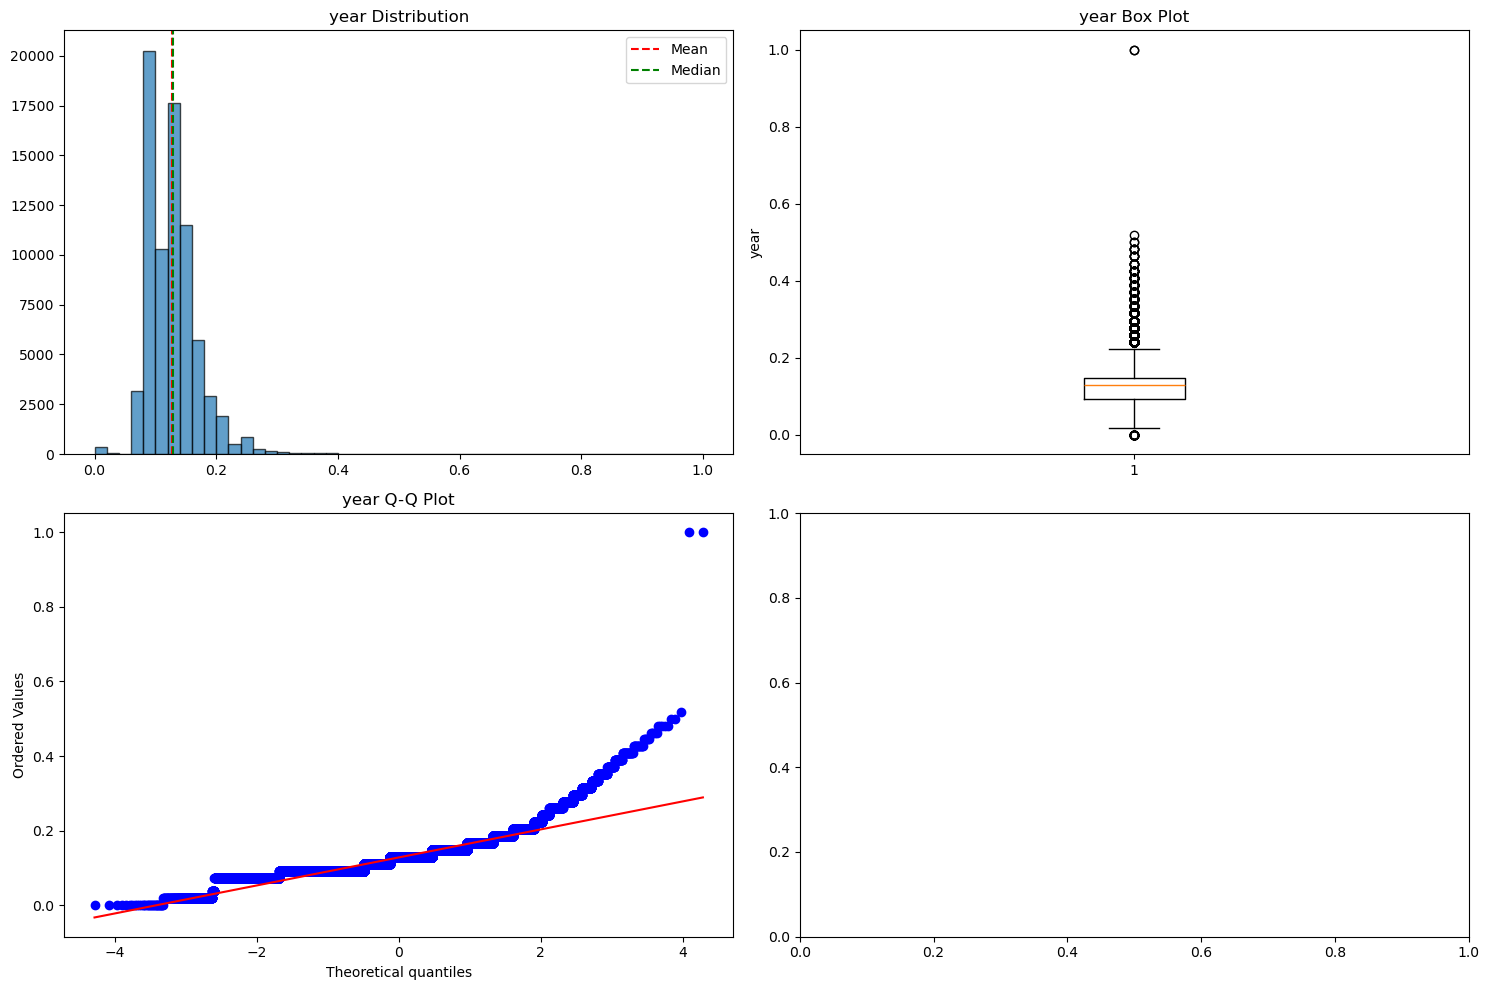


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Highly right-skewed - consider log transformation

=== TRANSFORMATION EXPERIMENTS FOR YEAR ===
log1p_abs: Skewness 1.913 → 1.507
log1p_shifted: Skewness 1.913 → 1.670
sqrt: Skewness 1.913 → 0.642


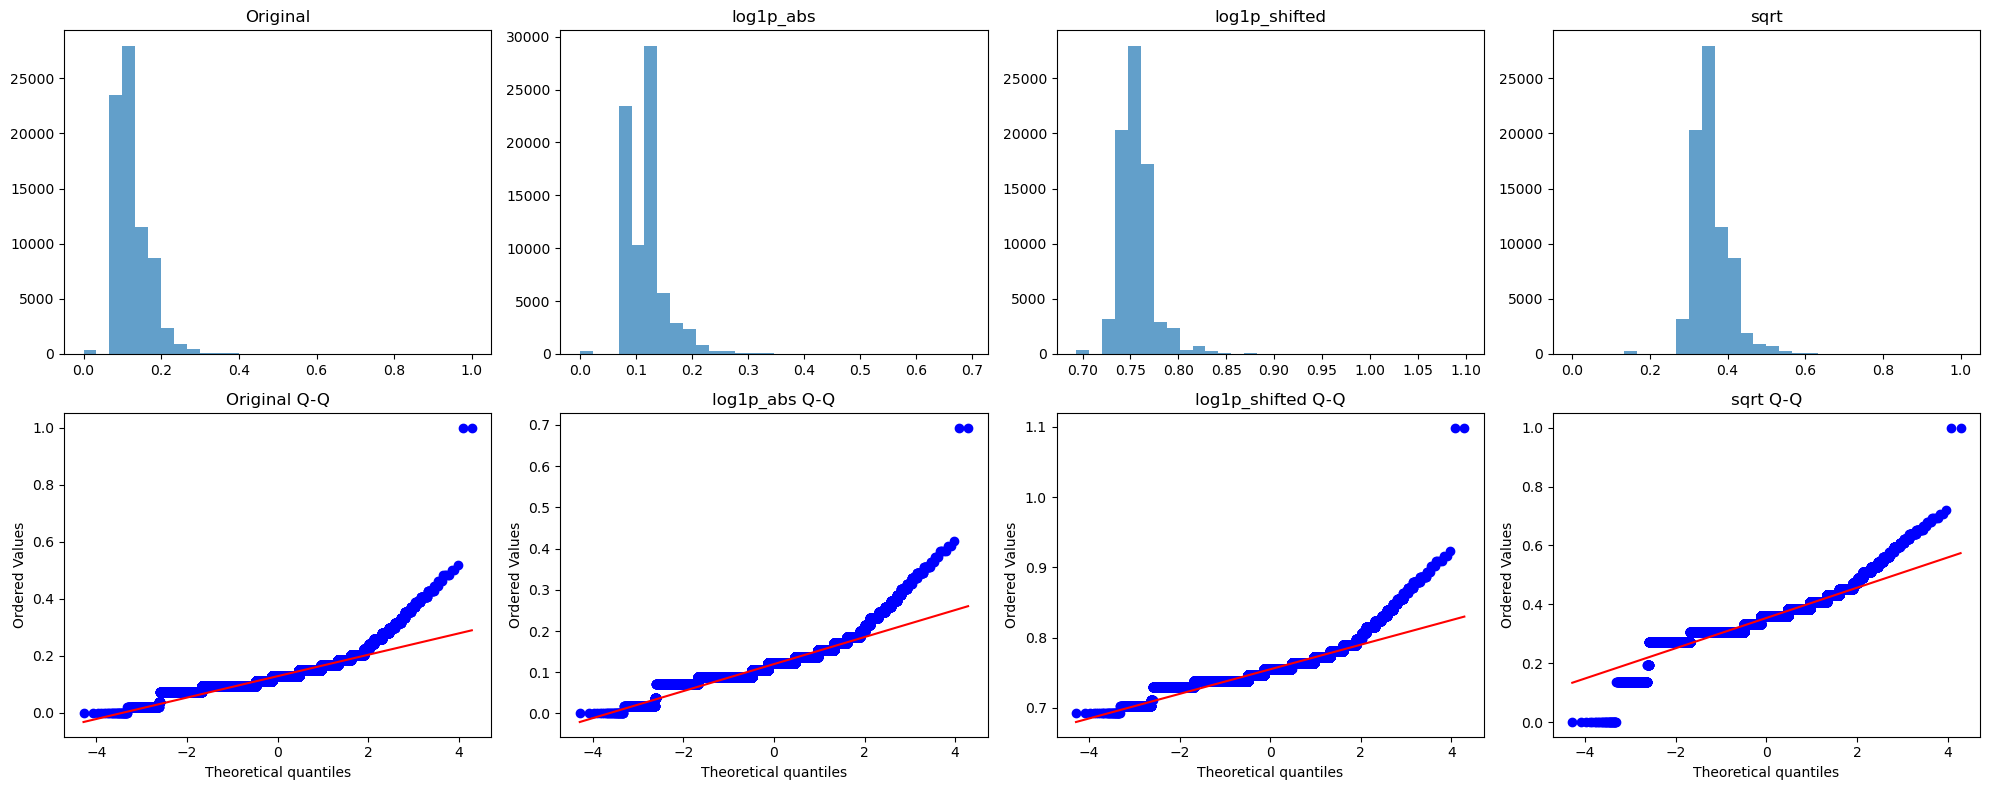







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: mileage ---
--------------------------------------------------

ANALYZING: MILEAGE
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: -5.567033359174808
Max: 1.126515163424222
Mean: -0.000
Median: 0.208
Std: 1.000
Skewness: -2.322
Kurtosis: 7.372

=== DATA QUALITY ASSESSMENT ===
Negative values: 28689 (37.76%)
Zero values: 0 (0.00%)
Outliers (IQR method): 3274 (4.31%)


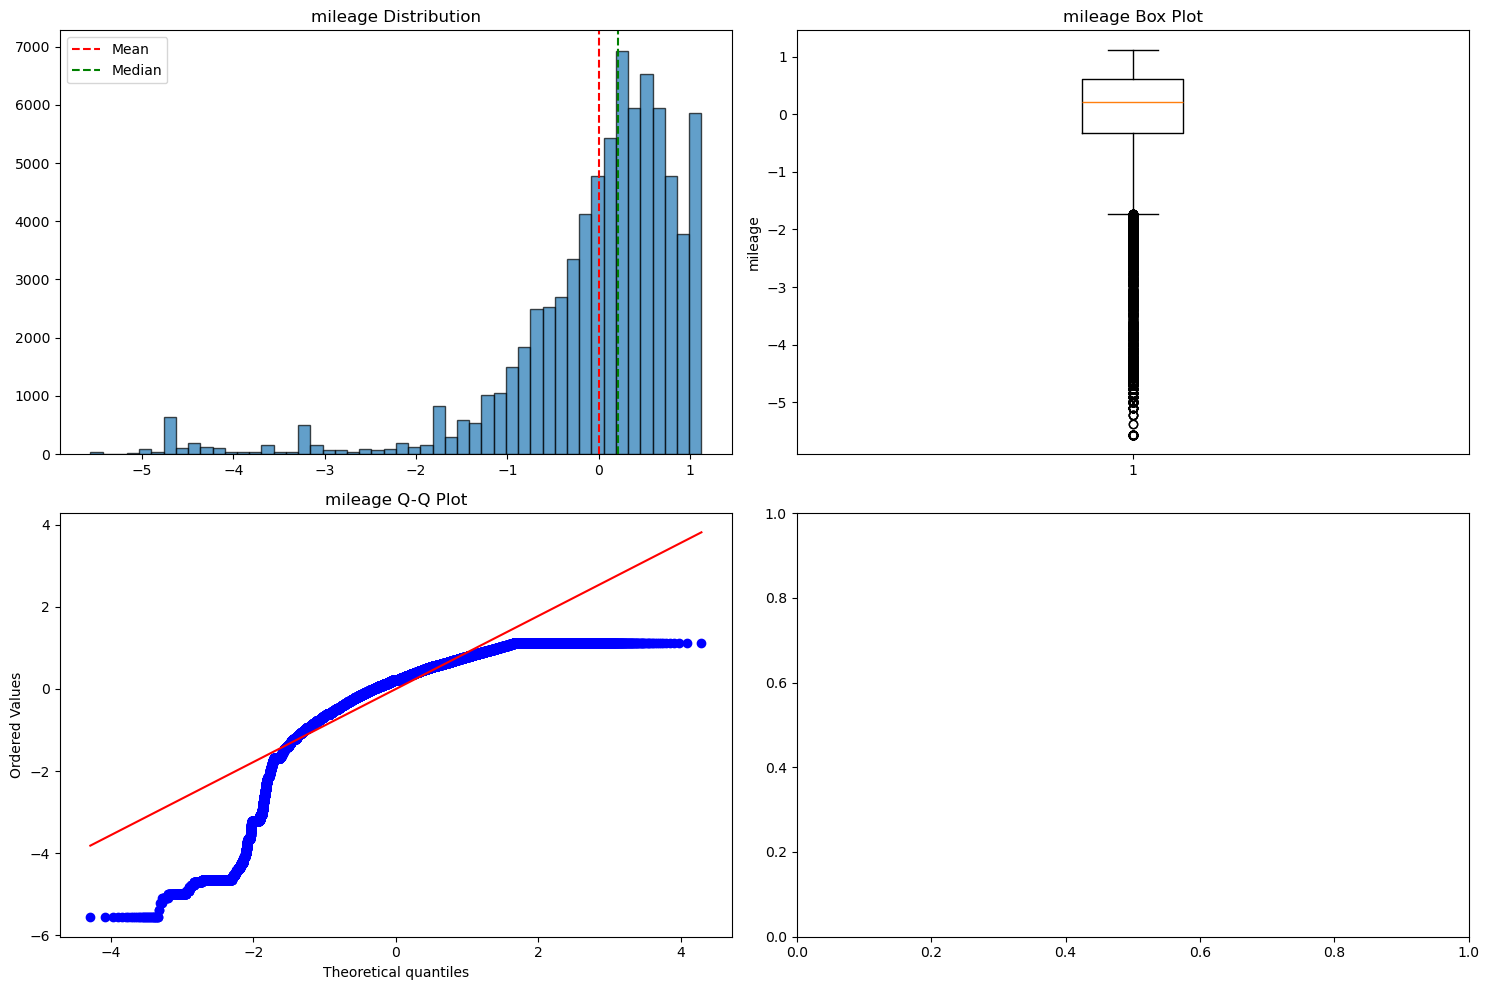


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset
⚠️  Highly left-skewed - consider power transformation

=== TRANSFORMATION EXPERIMENTS FOR MILEAGE ===
log1p_abs: Skewness -2.322 → 1.476
log1p_shifted: Skewness -2.322 → -3.516


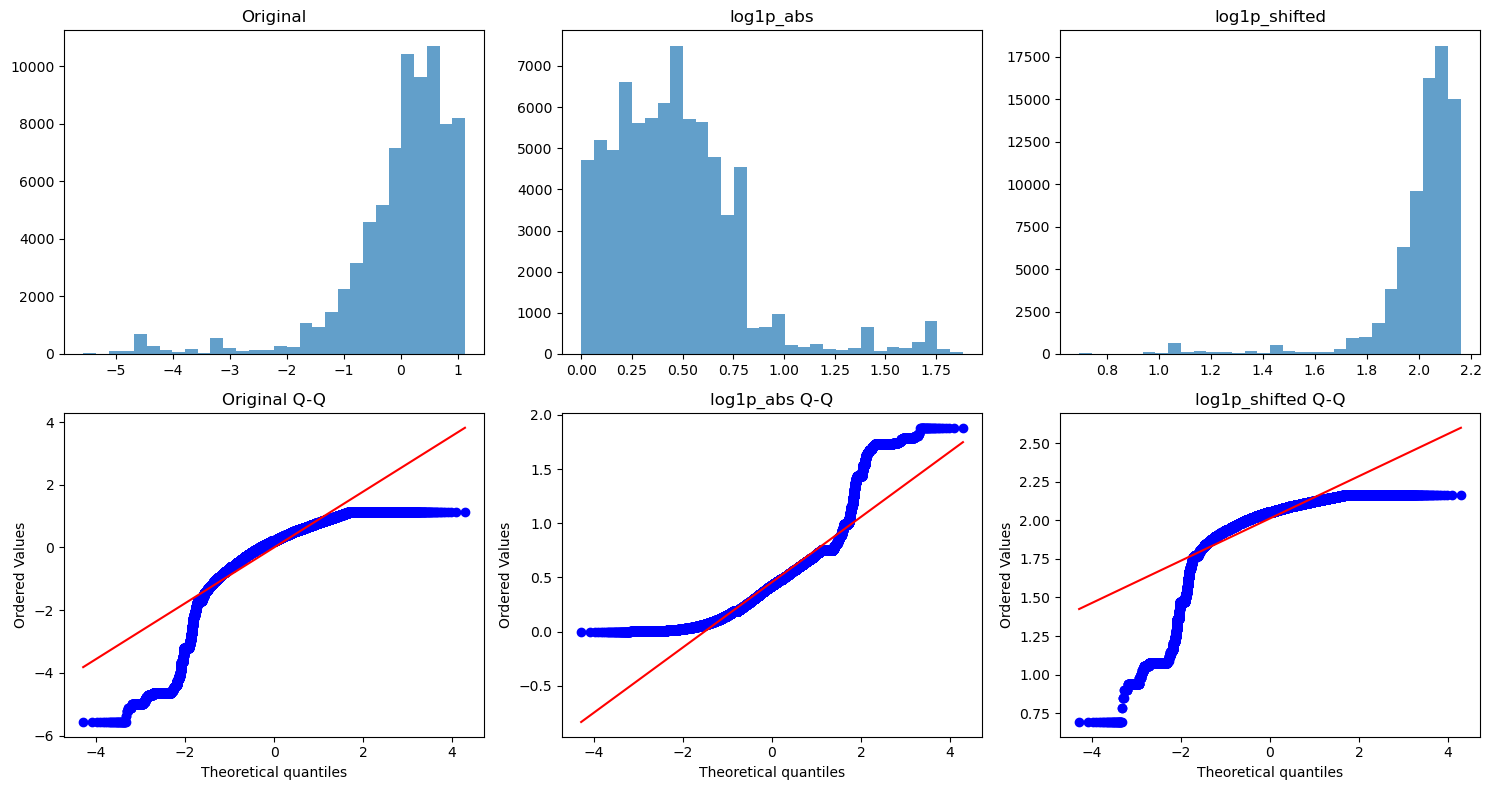







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: tax ---
--------------------------------------------------

ANALYZING: TAX
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: -3.425673248794659
Max: 7.316647051283683
Mean: 0.000
Median: 0.354
Std: 1.000
Skewness: -0.064
Kurtosis: 4.117

=== DATA QUALITY ASSESSMENT ===
Negative values: 16126 (21.23%)
Zero values: 0 (0.00%)
Outliers (IQR method): 20306 (26.73%)


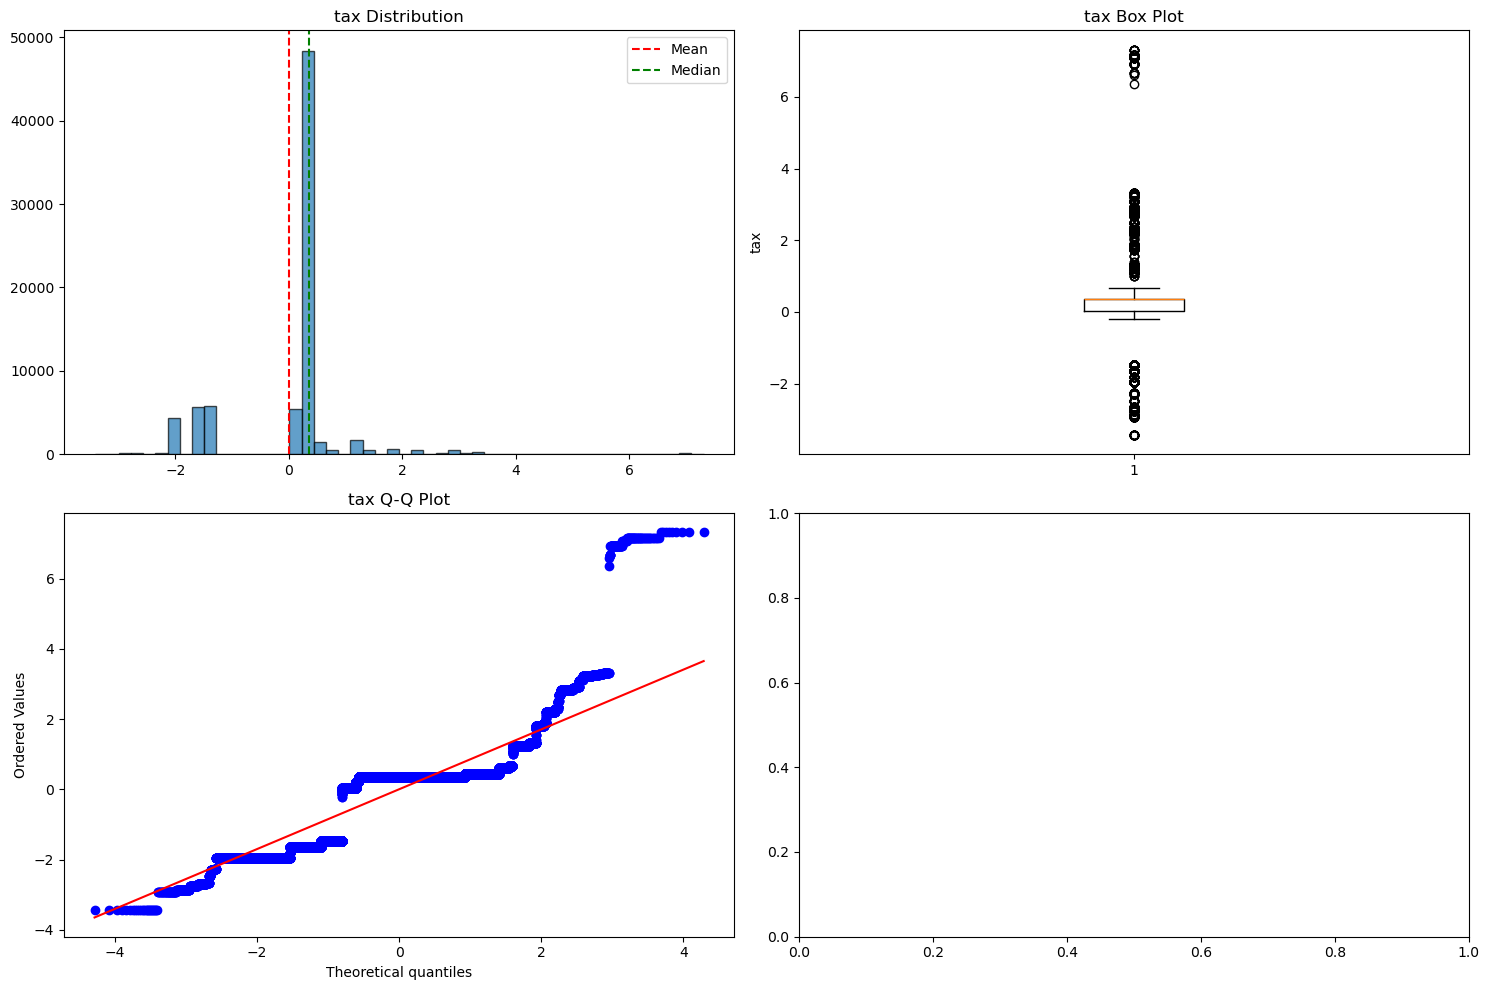


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset
⚠️  High percentage of outliers - consider outlier treatment

=== TRANSFORMATION EXPERIMENTS FOR TAX ===
log1p_abs: Skewness -0.064 → 1.117
log1p_shifted: Skewness -0.064 → -1.000


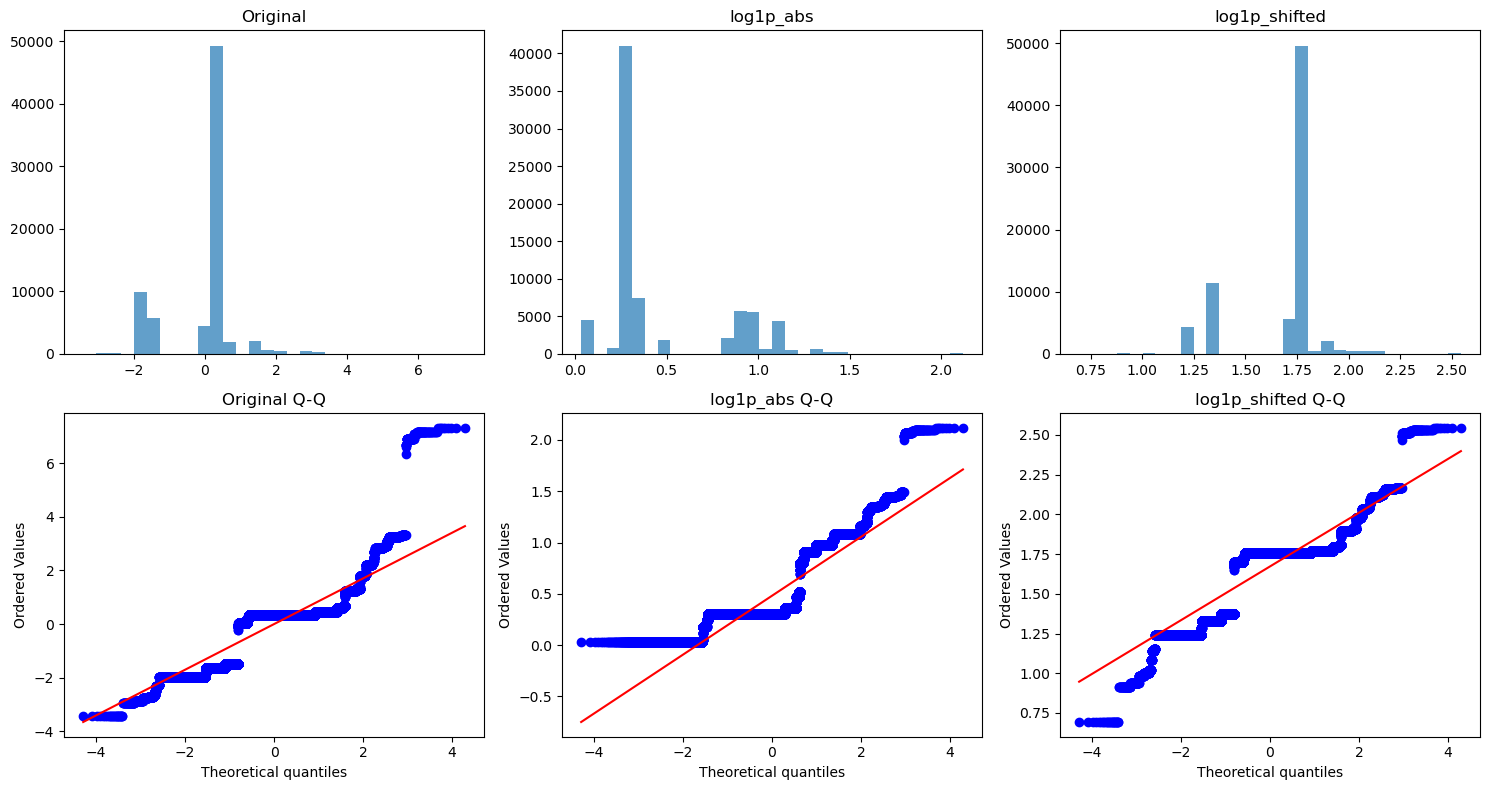







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: mpg ---
--------------------------------------------------

ANALYZING: MPG
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: -2.6113630833744854
Max: 2.551966455611215
Mean: -0.000
Median: -0.025
Std: 1.000
Skewness: 0.057
Kurtosis: 0.050

=== DATA QUALITY ASSESSMENT ===
Negative values: 42505 (55.95%)
Zero values: 0 (0.00%)
Outliers (IQR method): 0 (0.00%)


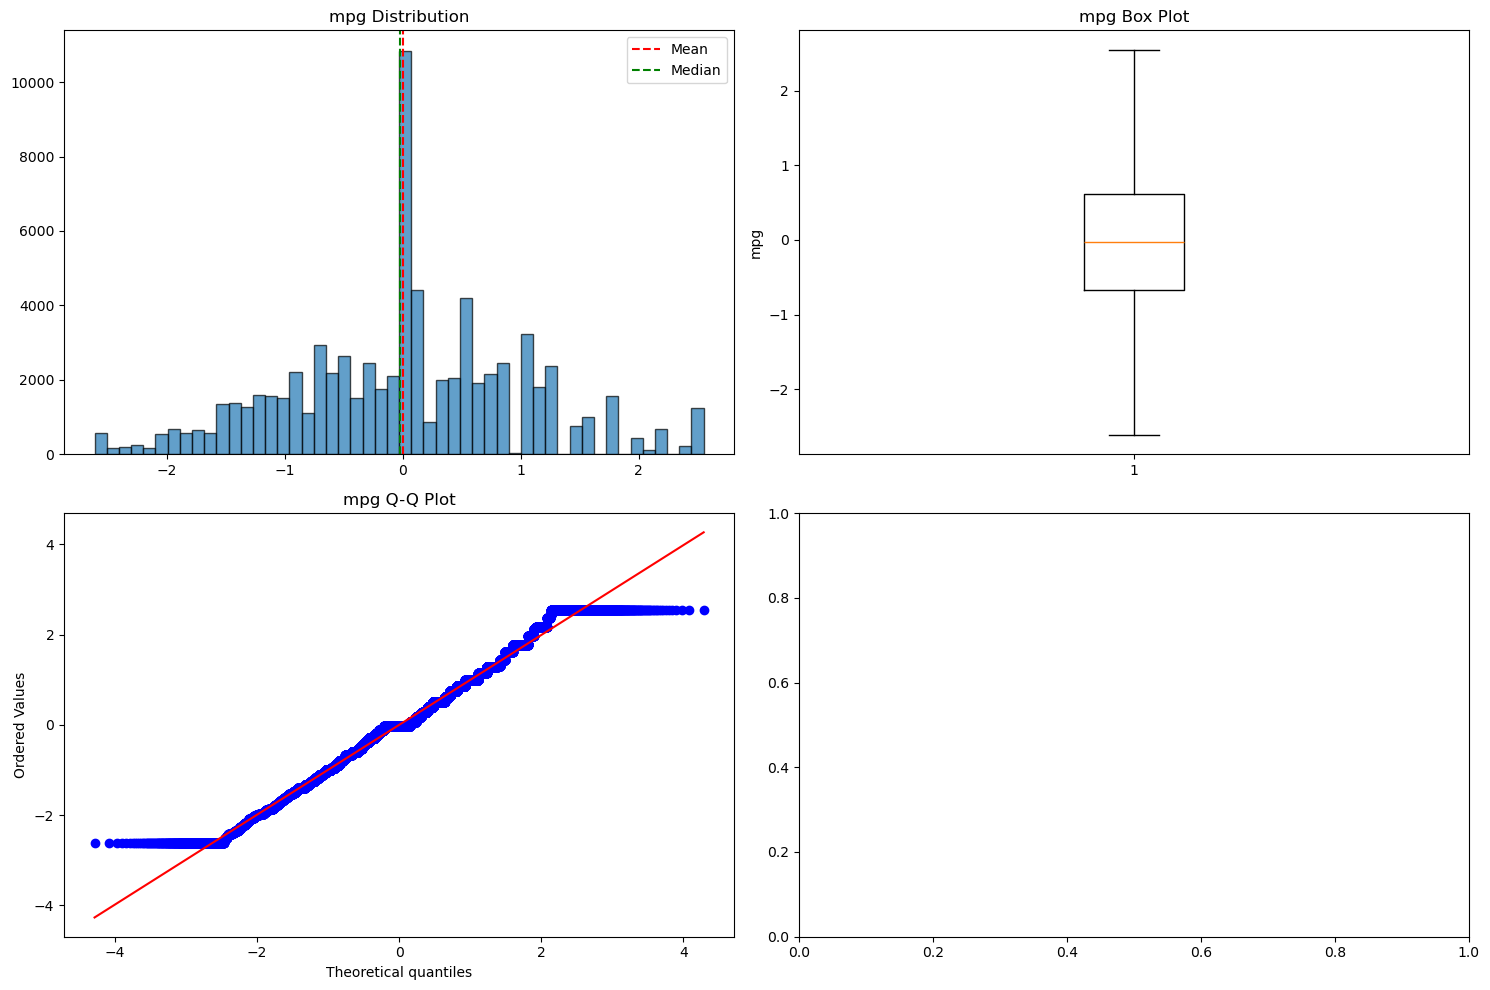


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset

=== TRANSFORMATION EXPERIMENTS FOR MPG ===
log1p_abs: Skewness 0.057 → 0.264
log1p_shifted: Skewness 0.057 → -0.687


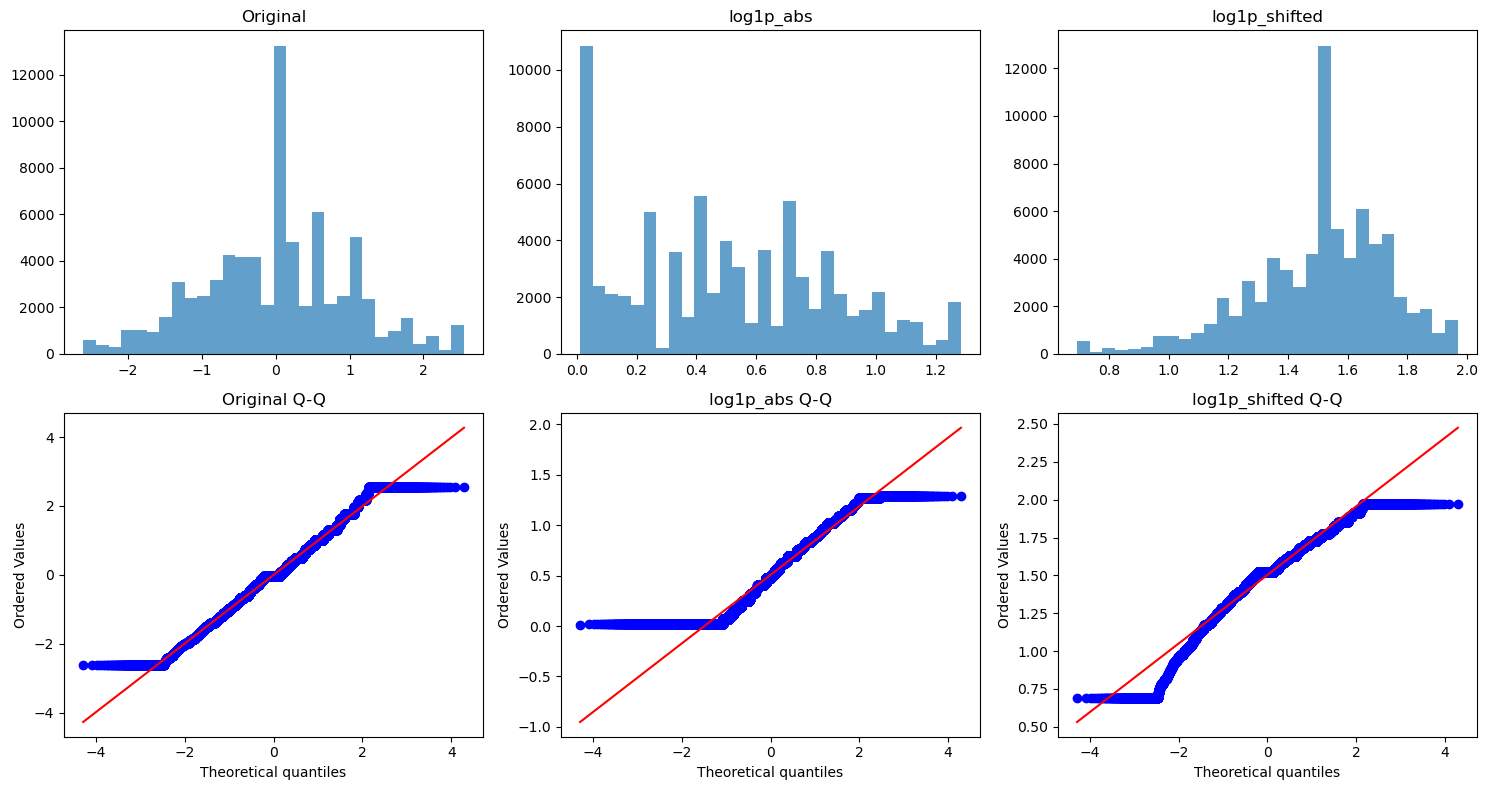







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: engineSize ---
--------------------------------------------------

ANALYZING: ENGINESIZE
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: -2.129365995797813
Max: 6.25
Mean: 0.074
Median: 0.000
Std: 0.710
Skewness: 1.251
Kurtosis: 4.597

=== DATA QUALITY ASSESSMENT ===
Negative values: 36832 (48.48%)
Zero values: 7897 (10.39%)
Outliers (IQR method): 716 (0.94%)


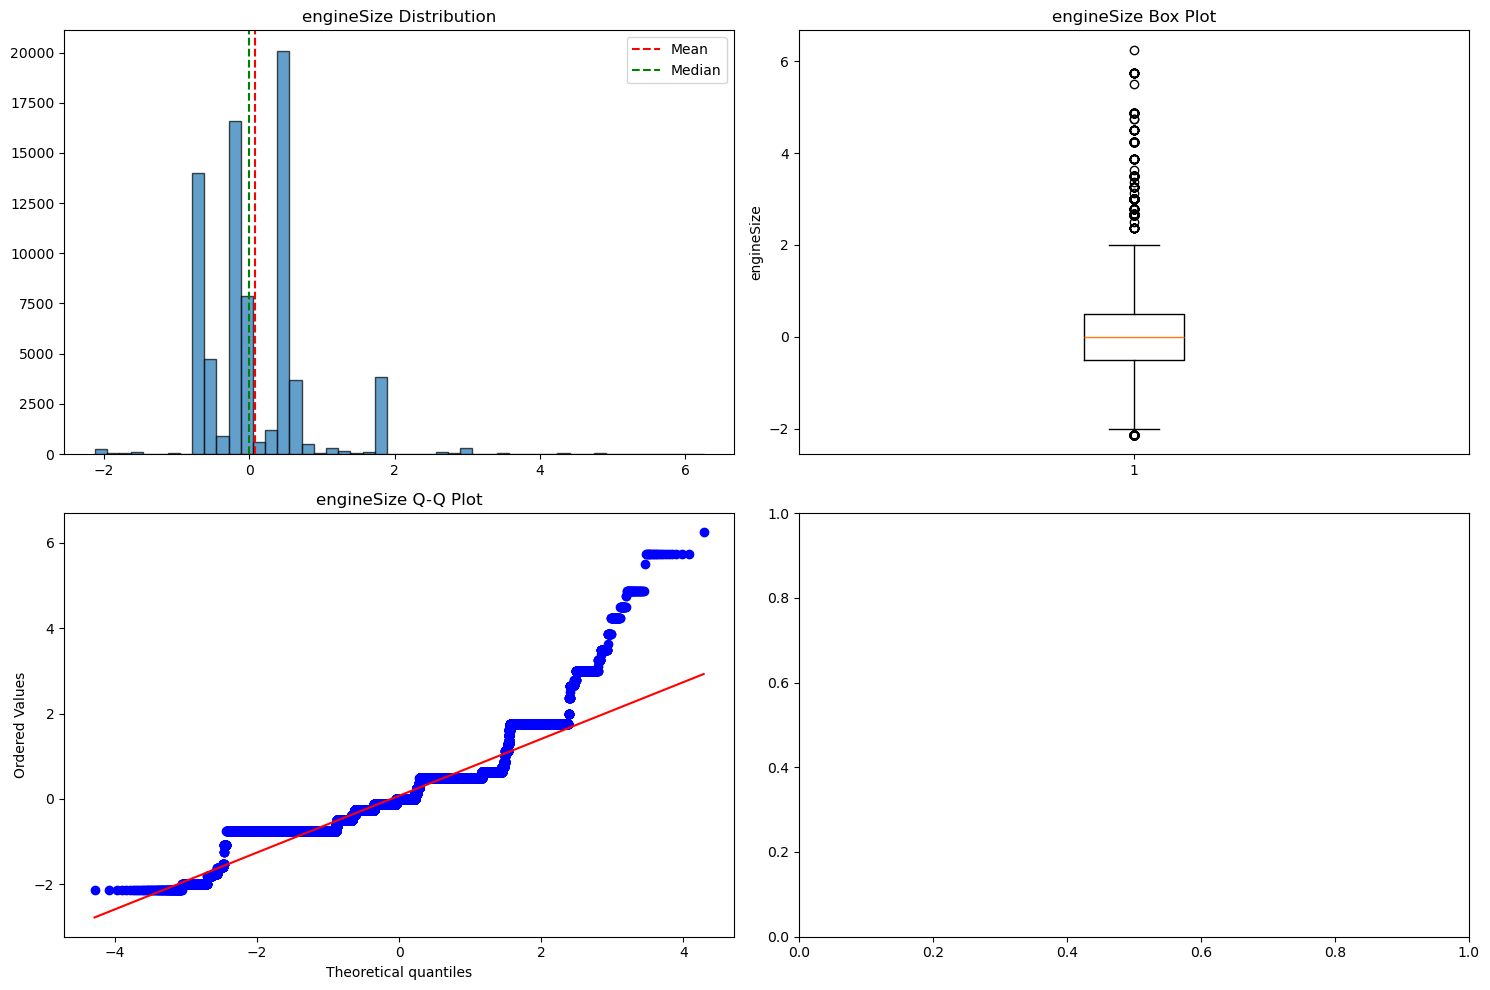


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset
⚠️  Highly right-skewed - consider log transformation
⚠️  Many zero values - consider log1p transformation

=== TRANSFORMATION EXPERIMENTS FOR ENGINESIZE ===
log1p_abs: Skewness 1.251 → 1.018
log1p_shifted: Skewness 1.251 → 0.275


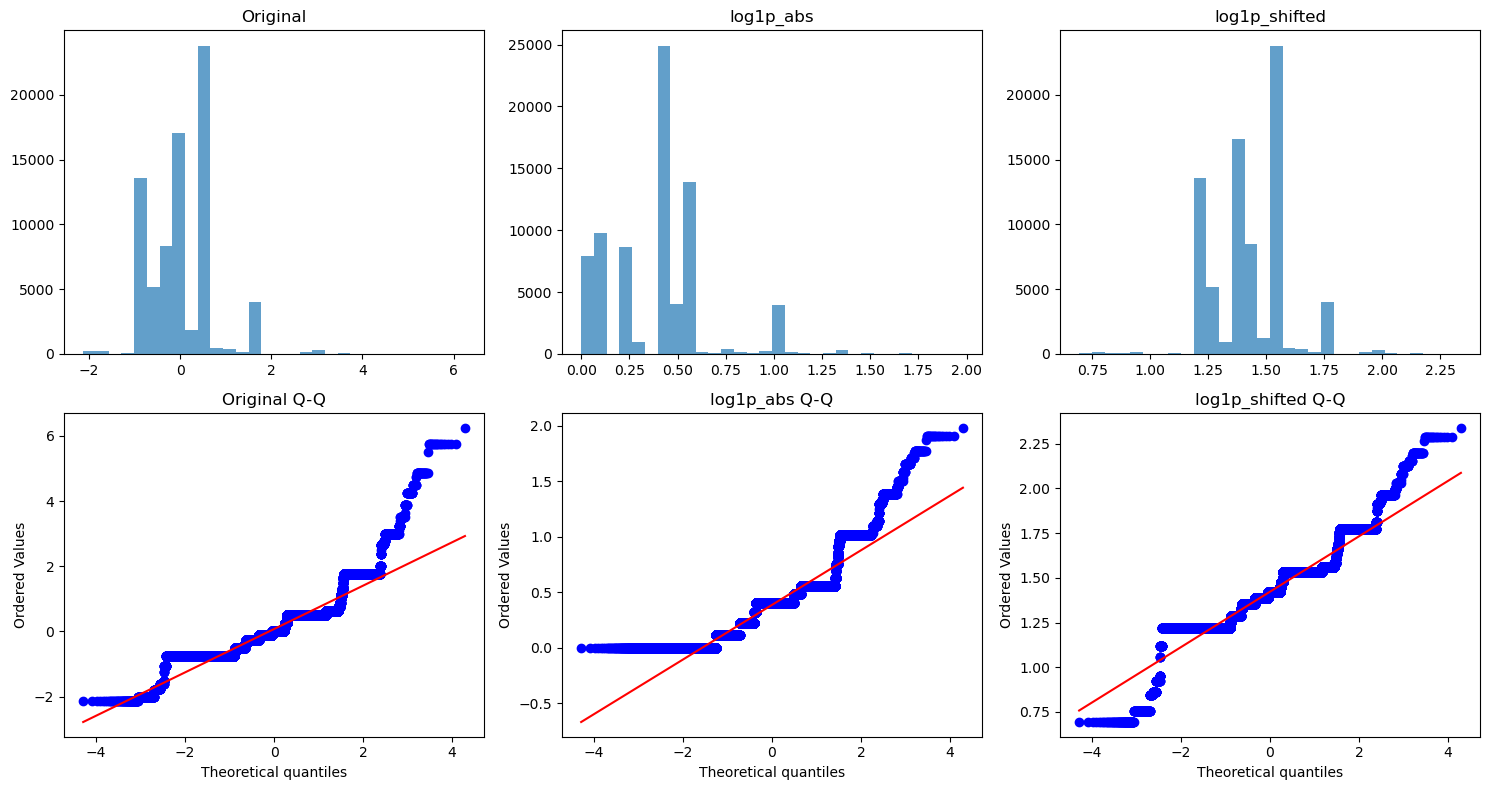







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: paintQuality% ---
--------------------------------------------------

ANALYZING: PAINTQUALITY%
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: 0.0
Max: 1.0
Mean: 0.639
Median: 0.644
Std: 0.209
Skewness: -0.095
Kurtosis: -0.924

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 19 (0.03%)
Outliers (IQR method): 0 (0.00%)


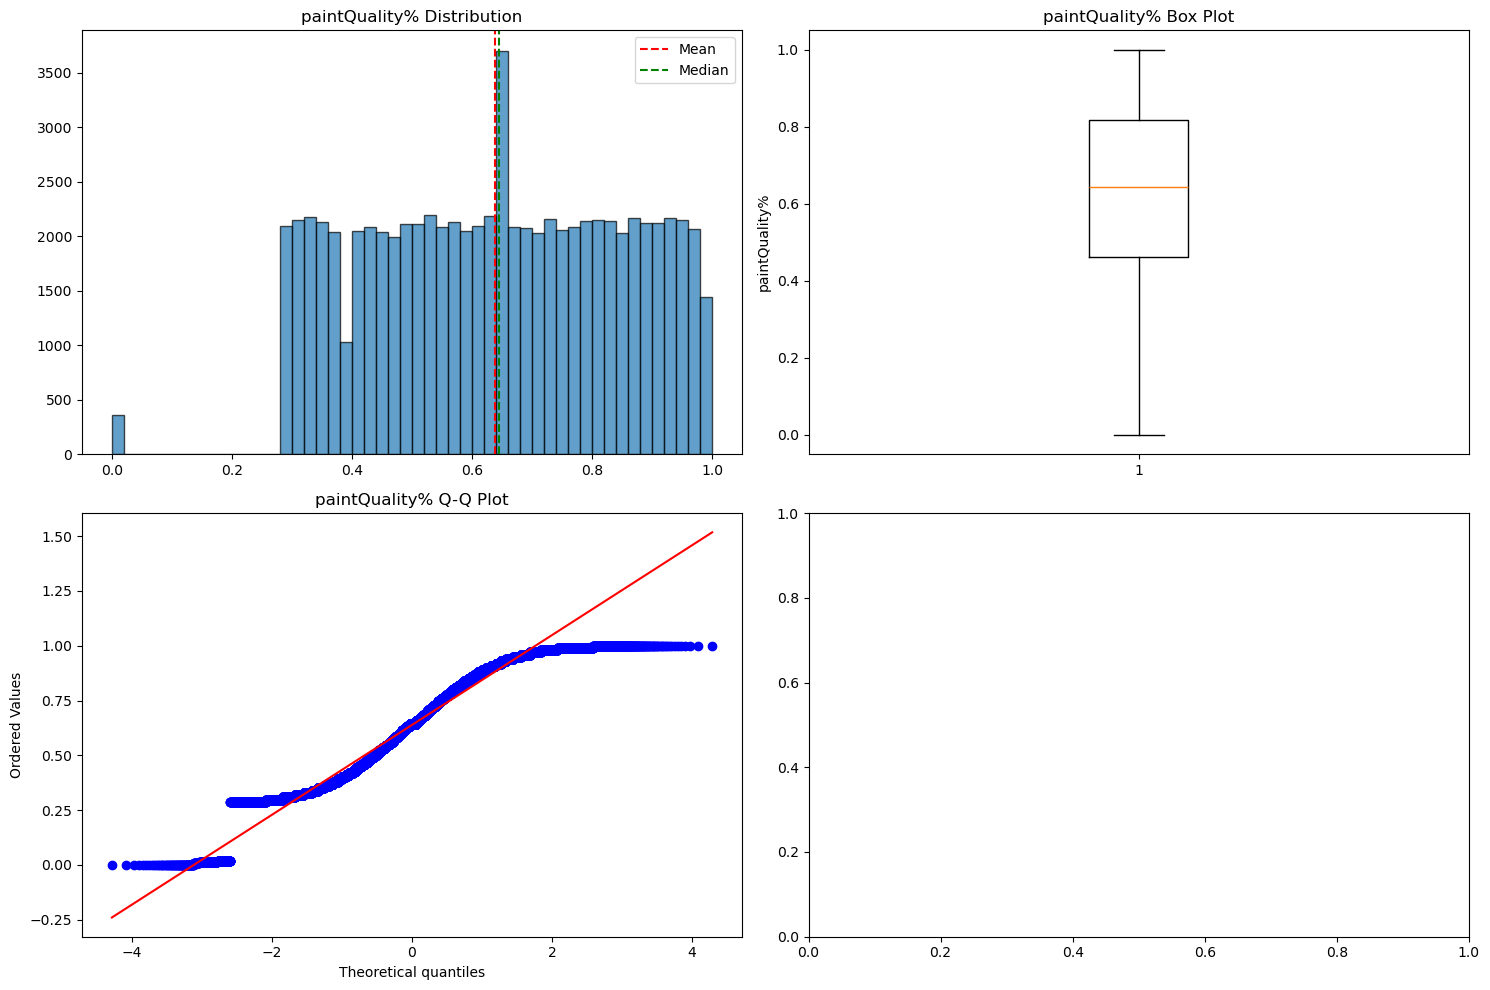


=== TRANSFORMATION SUGGESTIONS ===

=== TRANSFORMATION EXPERIMENTS FOR PAINTQUALITY% ===
log1p_abs: Skewness -0.095 → -0.332
log1p_shifted: Skewness -0.095 → -0.232
sqrt: Skewness -0.095 → -0.686


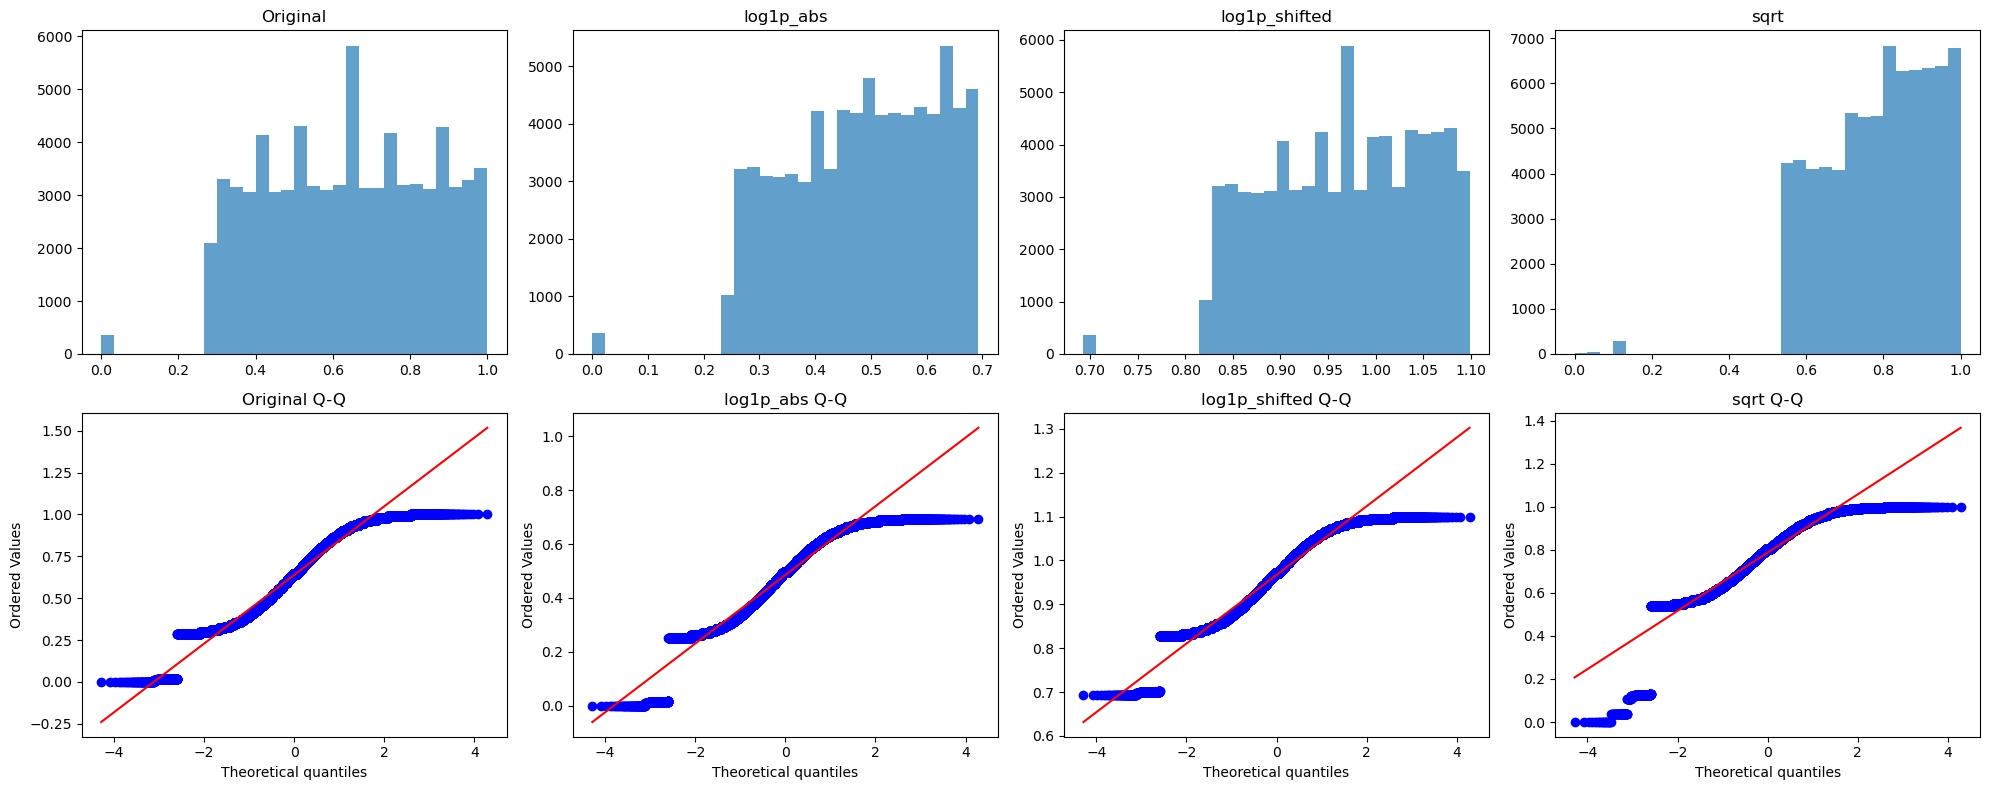







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: previousOwners ---
--------------------------------------------------

ANALYZING: PREVIOUSOWNERS
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: -1.7032642388059673
Max: 1.7317063870354181
Mean: 0.000
Median: 0.236
Std: 1.000
Skewness: -0.594
Kurtosis: -0.912

=== DATA QUALITY ASSESSMENT ===
Negative values: 29633 (39.00%)
Zero values: 0 (0.00%)
Outliers (IQR method): 0 (0.00%)


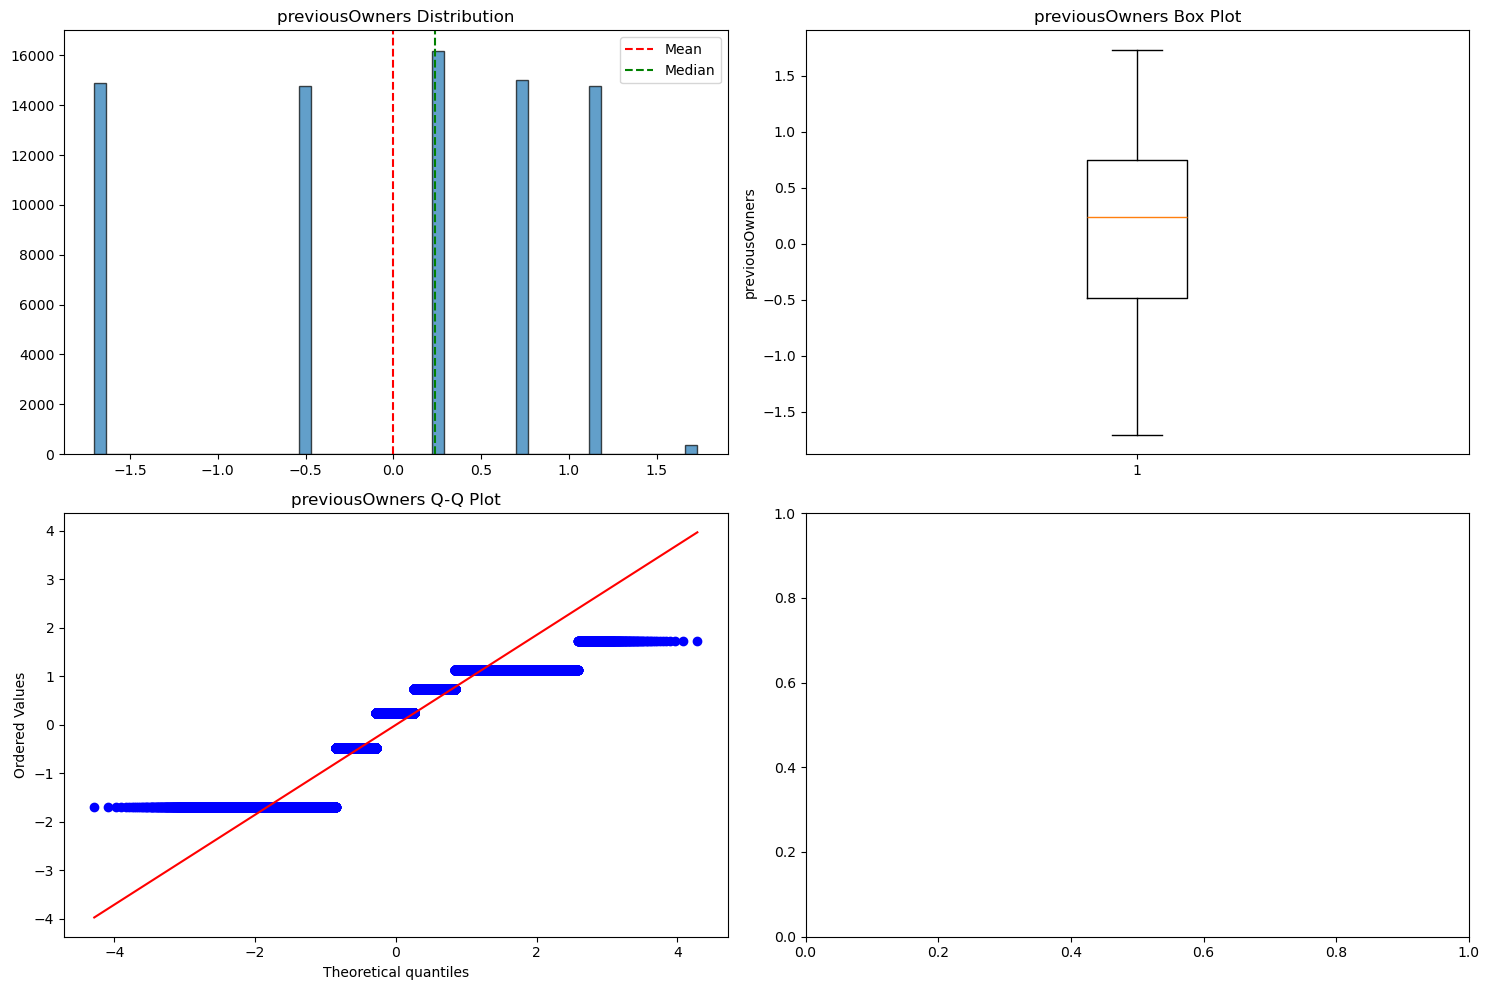


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset

=== TRANSFORMATION EXPERIMENTS FOR PREVIOUSOWNERS ===
log1p_abs: Skewness -0.594 → 0.183
log1p_shifted: Skewness -0.594 → -0.907


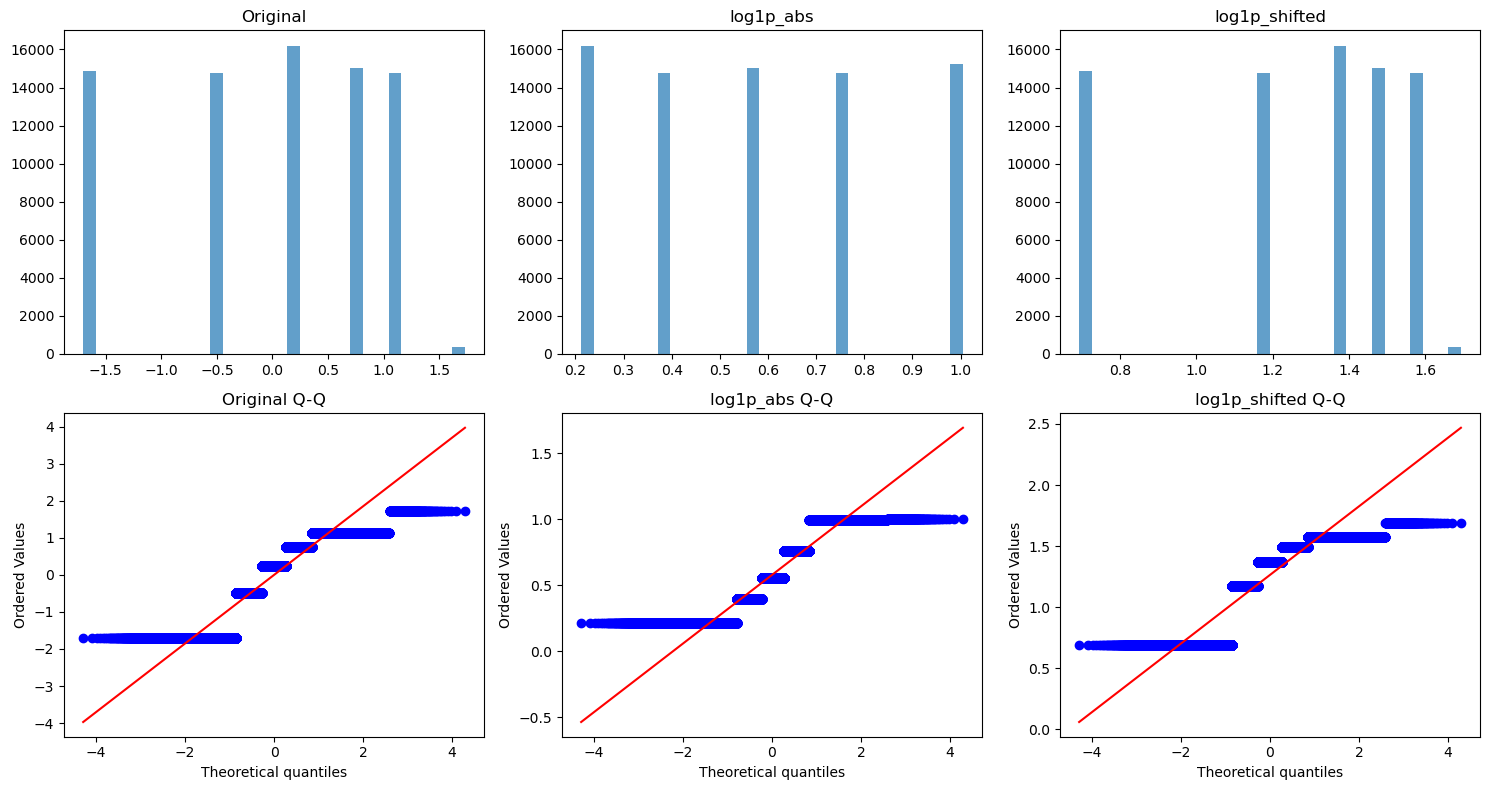







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: clean_make ---
--------------------------------------------------

ANALYZING: CLEAN_MAKE
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: 4229.666666666667
Max: 38186.985507246376
Mean: 16881.890
Median: 14389.139
Std: 5220.844
Skewness: 0.415
Kurtosis: -1.285

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 0 (0.00%)
Outliers (IQR method): 69 (0.09%)


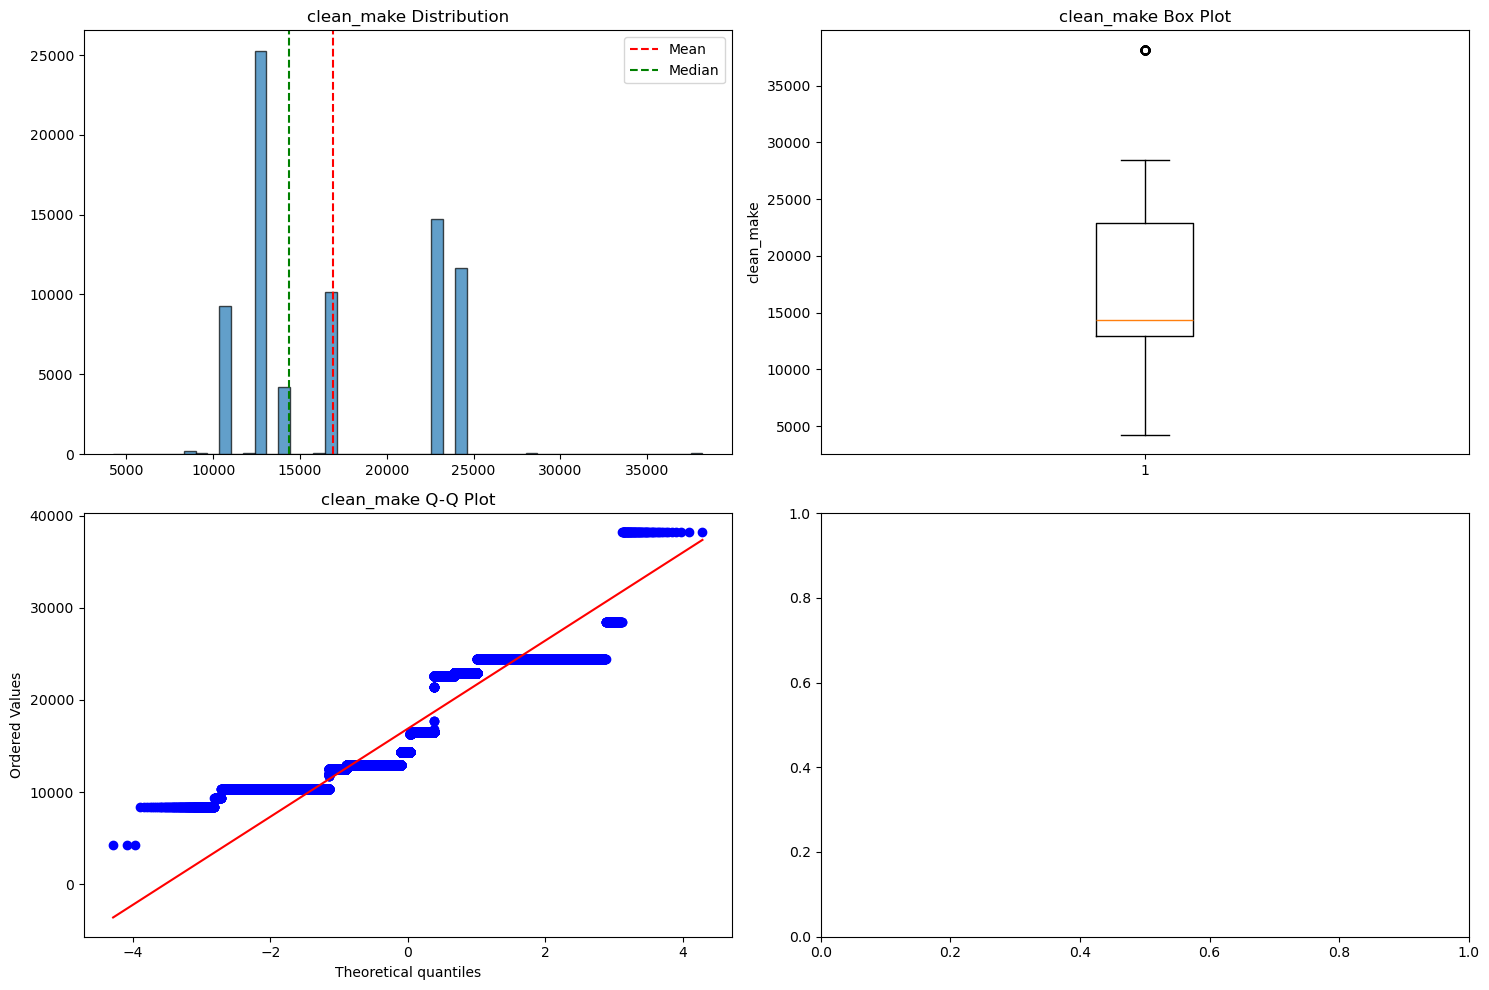


=== TRANSFORMATION SUGGESTIONS ===

=== TRANSFORMATION EXPERIMENTS FOR CLEAN_MAKE ===
log: Skewness 0.415 → 0.172
log1p: Skewness 0.415 → 0.172
sqrt: Skewness 0.415 → 0.298
boxcox_λ=-0.405: Skewness 0.415 → 0.056


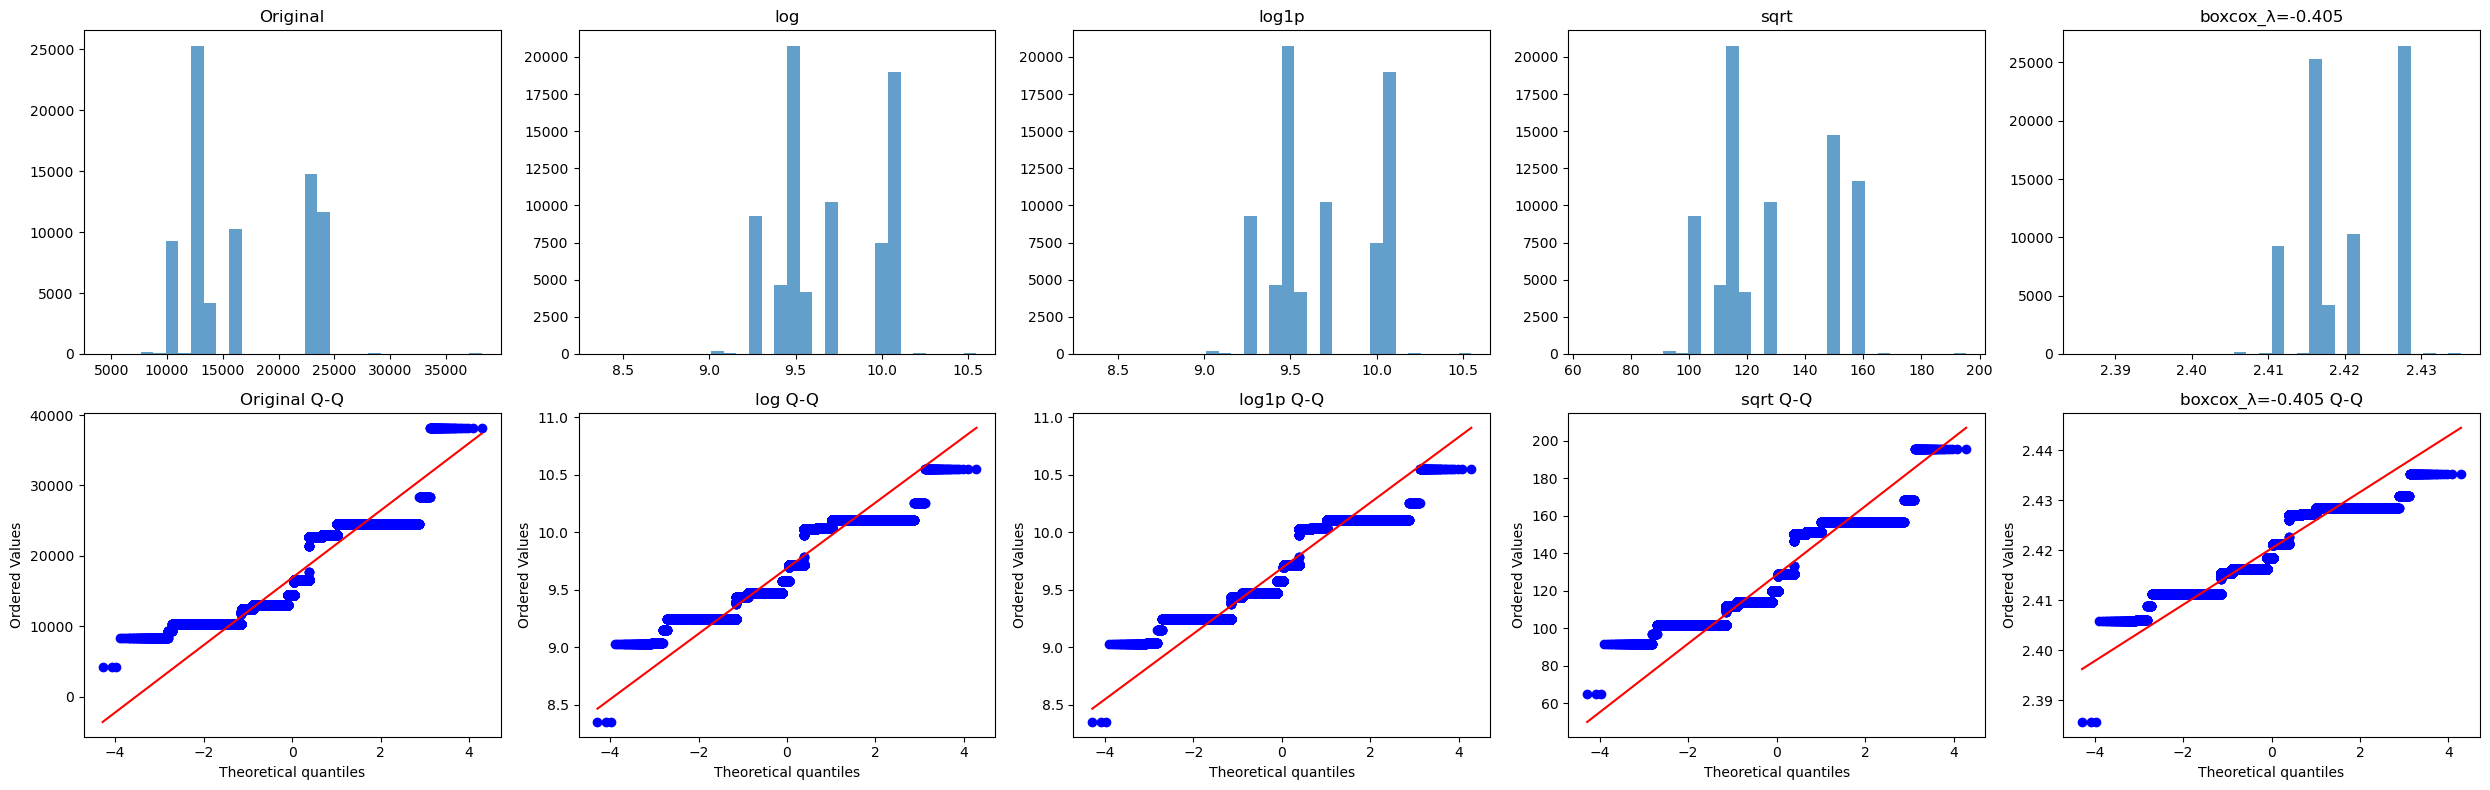







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: clean_model ---
--------------------------------------------------

ANALYZING: CLEAN_MODEL
=== BASIC STATISTICS ===
Count: 75973
Missing: 0
Missing %: 0.000
Min: 1295.0
Max: 100838.44444444444
Mean: 16881.890
Median: 14605.782
Std: 7335.387
Skewness: 1.969
Kurtosis: 10.024

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 0 (0.00%)
Outliers (IQR method): 1890 (2.49%)


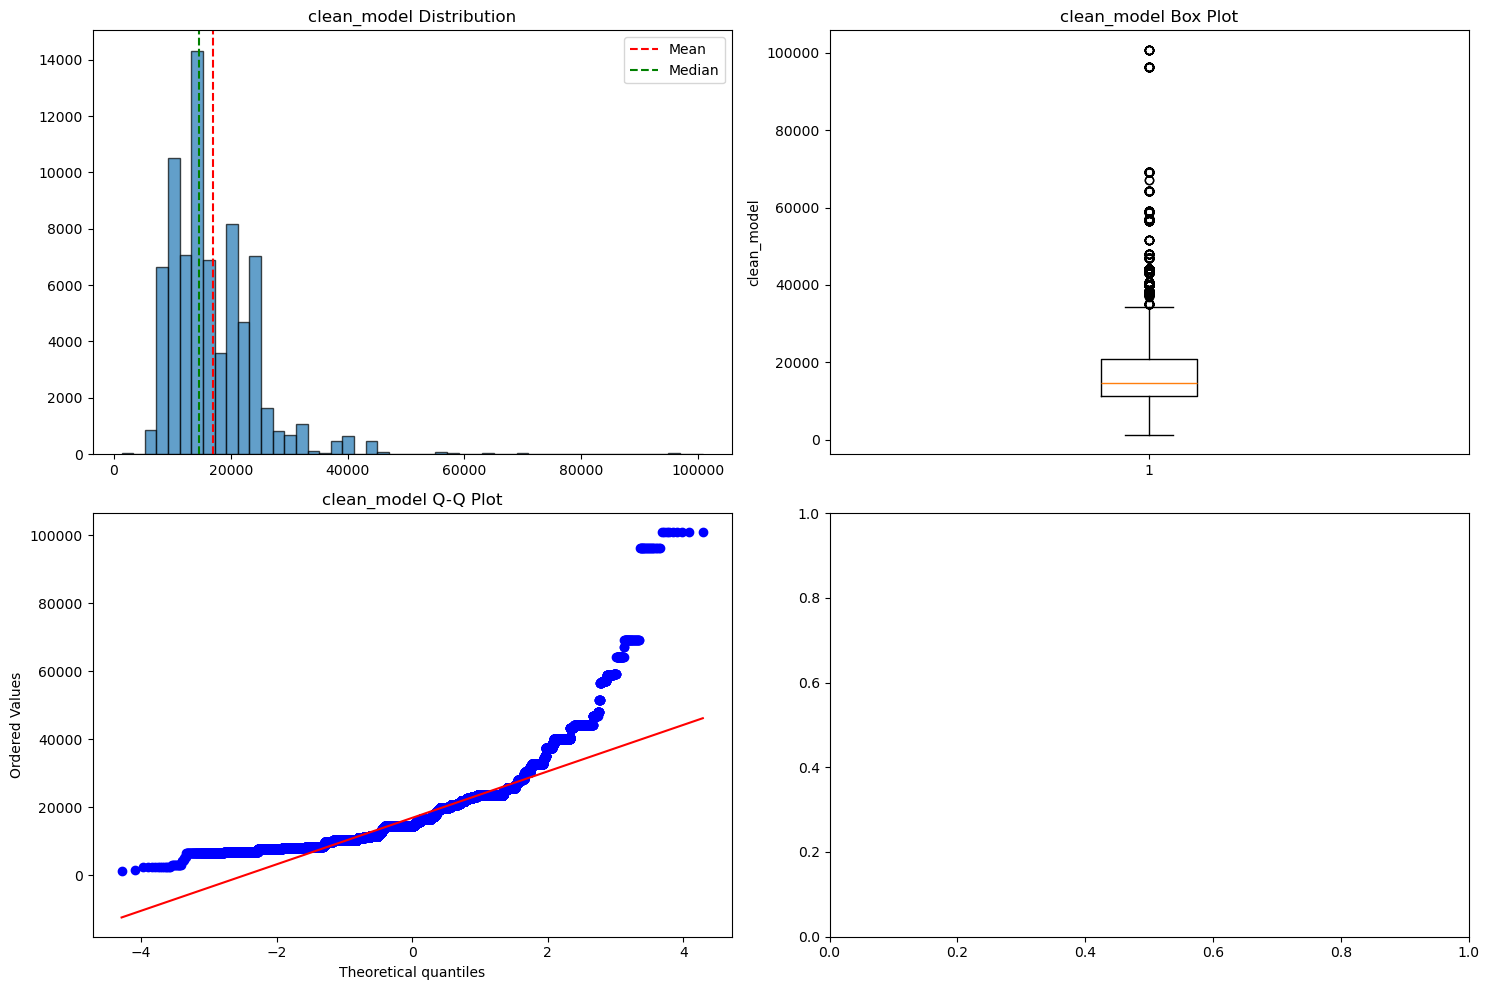


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Highly right-skewed - consider log transformation

=== TRANSFORMATION EXPERIMENTS FOR CLEAN_MODEL ===
log: Skewness 1.969 → 0.167
log1p: Skewness 1.969 → 0.167
sqrt: Skewness 1.969 → 0.854
boxcox_λ=-0.144: Skewness 1.969 → 0.002


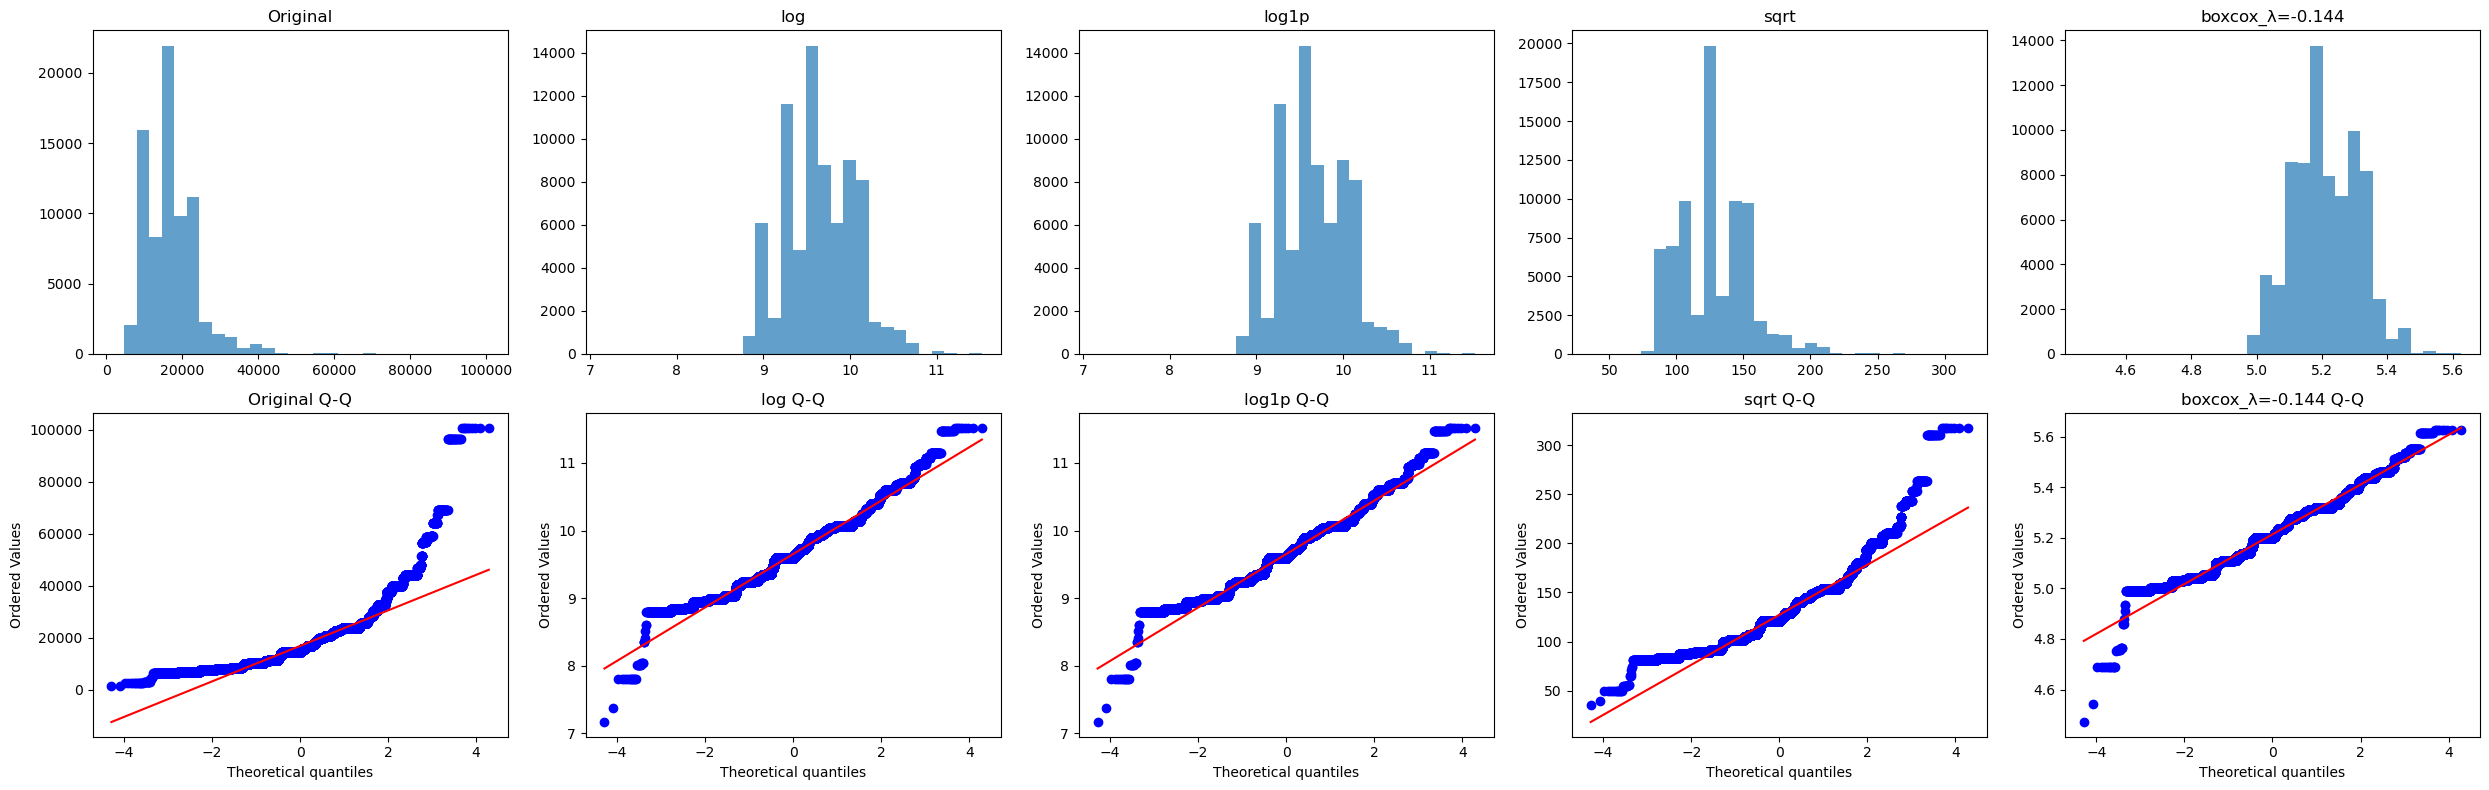

In [11]:
boolean_features = X_train.columns[X_train.nunique() == 2].tolist()
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feat for feat in numerical_features if feat not in boolean_features]
for feature in numerical_features:
    print("-"*50)
    print(f"--- ANALYZING NUMERICAL FEATURE: {feature} ---")
    print("-"*50)
    analyze_numerical_feature(X_train, feature)
    suggest_transformations(X_train, feature)
    
    print("\n\n\n\n\n")


## Analize Categorical Features

--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: transmission ---
--------------------------------------------------

ANALYZING: TRANSMISSION
=== BASIC STATISTICS ===
Total records: 75,973
Missing values: 0 (0.00%)
Unique values: 4
Cardinality ratio: 0.000

=== TOP 4 VALUES ===
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Other         2263
Name: count, dtype: int64


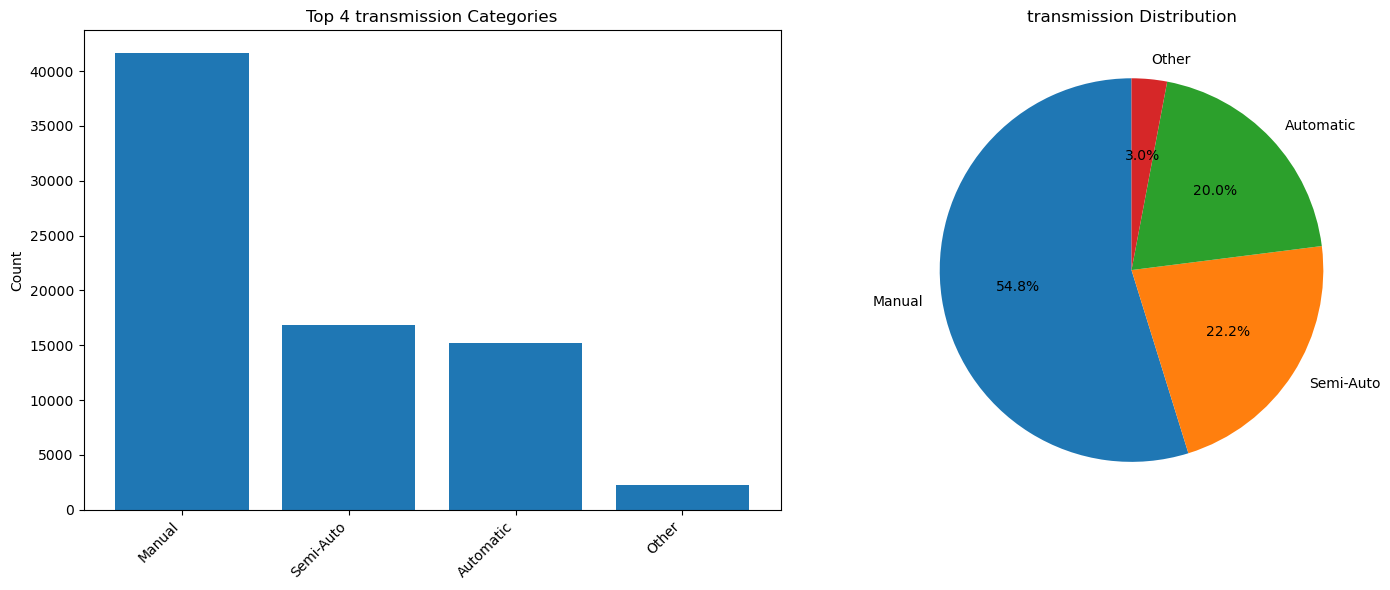


=== DATA QUALITY ASSESSMENT ===

=== ENCODING SUGGESTIONS ===
✓ Low cardinality - use One-Hot Encoding


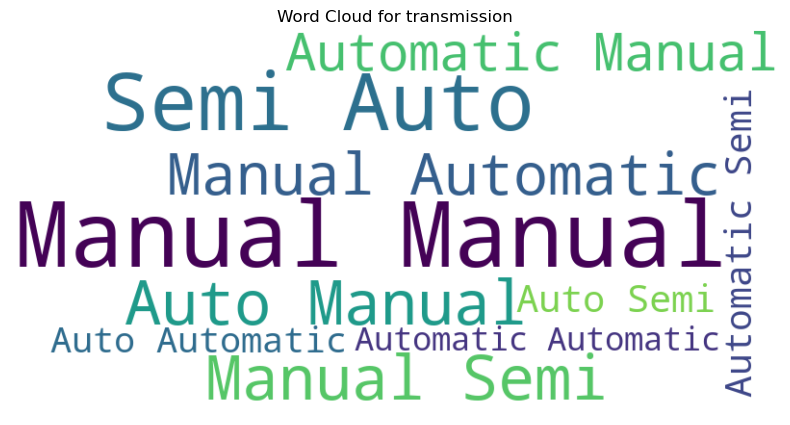







--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: fuelType ---
--------------------------------------------------

ANALYZING: FUELTYPE
=== BASIC STATISTICS ===
Total records: 75,973
Missing values: 0 (0.00%)
Unique values: 5
Cardinality ratio: 0.000

=== TOP 5 VALUES ===
fuelType
Petrol      41181
Diesel      30885
Hybrid       2225
Other        1678
Electric        4
Name: count, dtype: int64


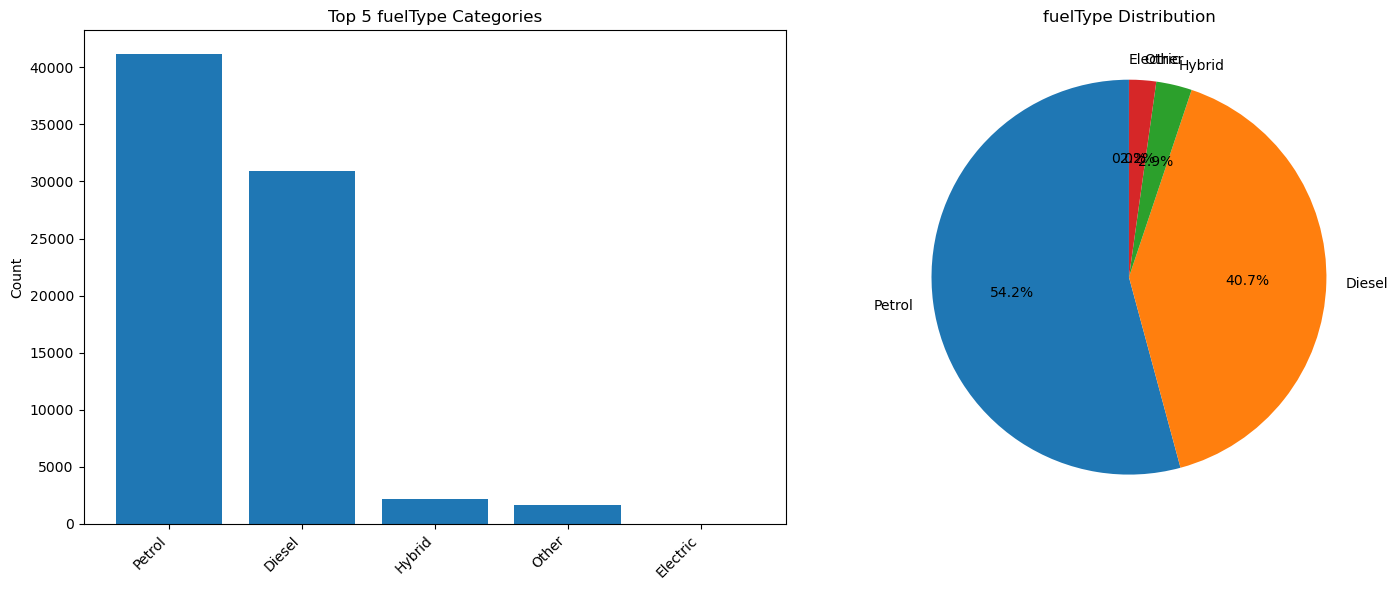


=== DATA QUALITY ASSESSMENT ===
⚠️  1 rare categories (< 1.0% of data)
Consider grouping into 'Other' category

=== ENCODING SUGGESTIONS ===
✓ Low cardinality - use One-Hot Encoding


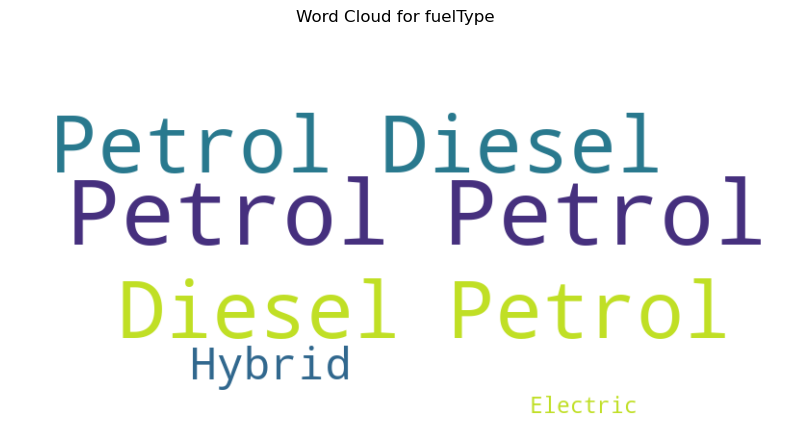







--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: clean_make ---
--------------------------------------------------

ANALYZING: CLEAN_MAKE
=== BASIC STATISTICS ===
Total records: 75,973
Missing values: 1,521 (2.00%)
Unique values: 21
Cardinality ratio: 0.000

=== TOP 20 VALUES ===
clean_make
ford                        16061
mercedes-benz               11674
volkswagen                  10168
opel                         9286
bmw                          7427
audi                         7326
toyota                       4539
skoda                        4198
hyundai                      3172
None                         1521
aston martin                  105
ferrari                        91
chevrolet                      83
nissan                         80
infiniti                       78
plymouth                       69
bentley                        66
avanti motor corporation       18
pontiac                         4
volvo              

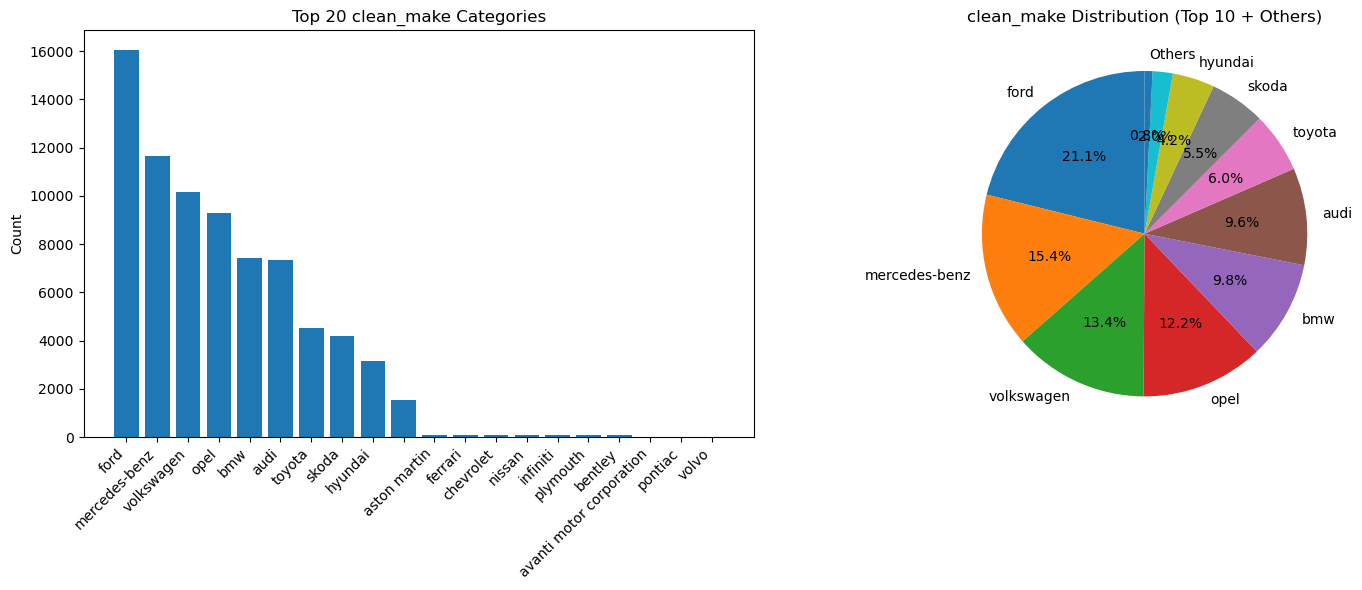


=== DATA QUALITY ASSESSMENT ===
⚠️  High cardinality feature - check for spelling variations
⚠️  12 rare categories (< 1.0% of data)
Consider grouping into 'Other' category

=== ENCODING SUGGESTIONS ===
⚠️  Medium cardinality - consider Target Encoding or Ordinal Encoding


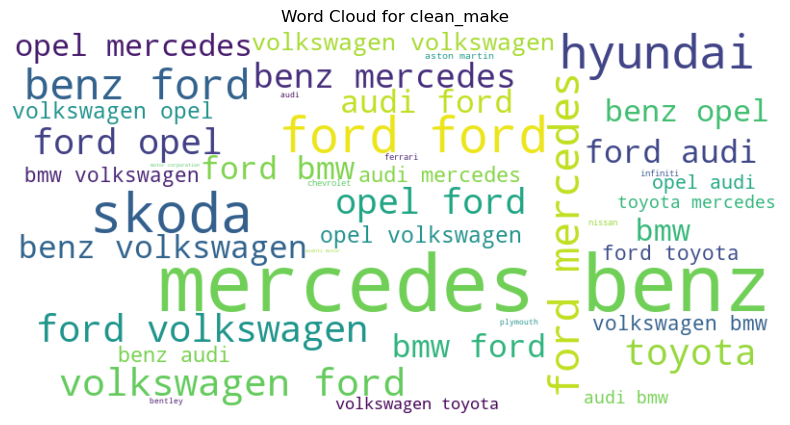







--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: clean_model ---
--------------------------------------------------

ANALYZING: CLEAN_MODEL
=== BASIC STATISTICS ===
Total records: 75,973
Missing values: 5,096 (6.71%)
Unique values: 163
Cardinality ratio: 0.002

=== TOP 20 VALUES ===
clean_model
focus       6964
c class     5288
None        5096
fiesta      4470
golf        3515
corsa       2359
polo        2221
mokka       2017
astra       1934
a class     1929
yaris       1920
3 series    1689
aygo        1381
1 series    1358
e class     1310
a3          1285
tiguan      1278
fabia       1069
octavia     1021
a1          1015
Name: count, dtype: int64


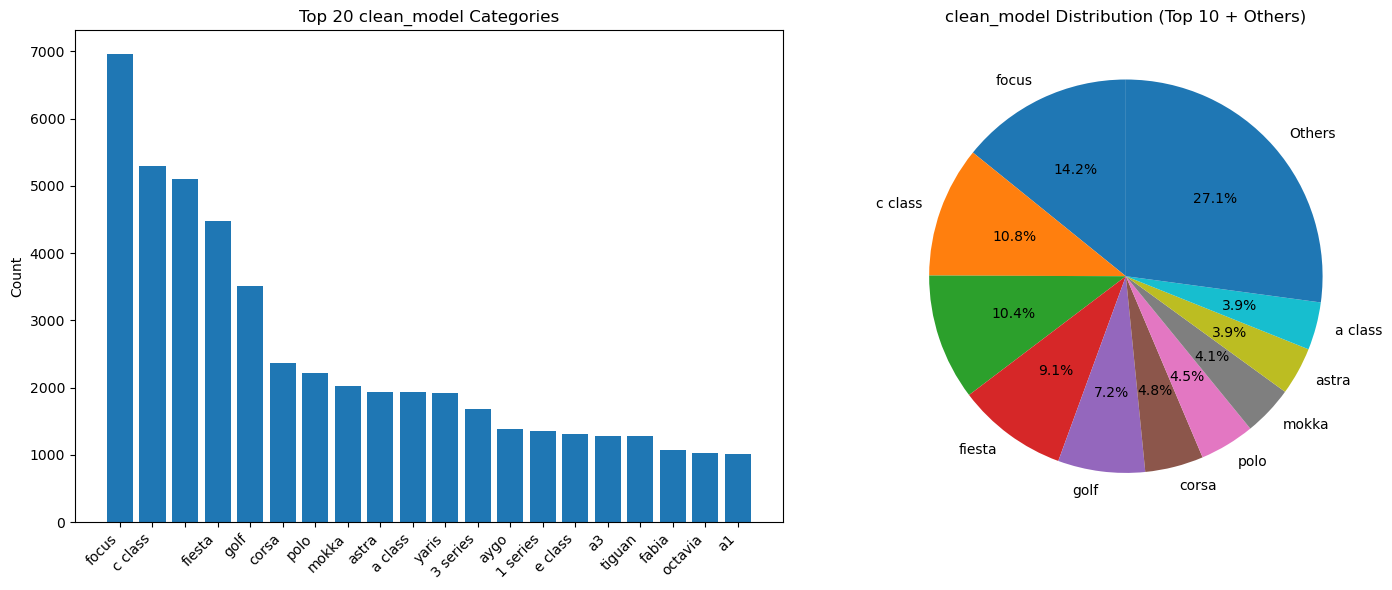


=== DATA QUALITY ASSESSMENT ===
⚠️  High cardinality feature - check for spelling variations
⚠️  139 rare categories (< 1.0% of data)
Consider grouping into 'Other' category

=== ENCODING SUGGESTIONS ===
⚠️  High cardinality - consider:
  - Target/Mean Encoding
  - Feature hashing
  - Dimensionality reduction
  - Grouping rare categories


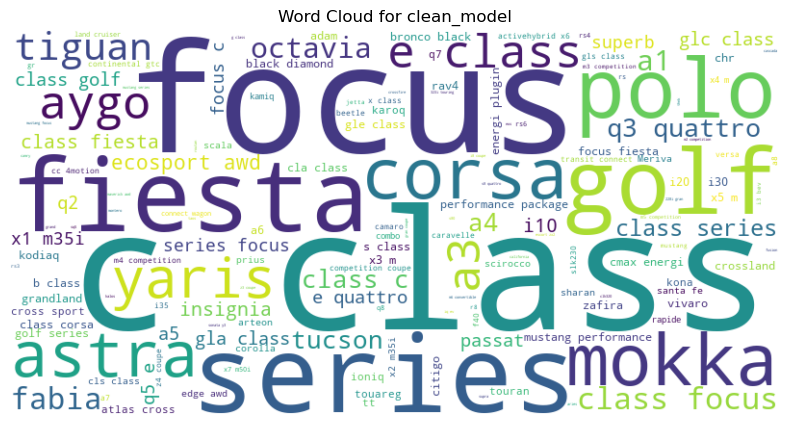

In [12]:
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
for feature in categorical_features:
    print("-"*50)
    print(f"--- ANALYZING CATEGORICAL FEATURE: {feature} ---")
    print("-"*50)
    analyze_categorical_feature(train_data, feature)
    # Plot the word cloud   
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data[feature].dropna().astype(str)))
    plt.figure(figsize=(10, 5))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {feature}")
    plt.show()
    
    print("\n\n\n\n\n")

## Analize Boolean Features

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: hasDamage ---
--------------------------------------------------
Value counts for hasDamage:
hasDamage
0.0    74425
1.0     1548
Name: count, dtype: int64

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: transmission_Automatic ---
--------------------------------------------------
Value counts for transmission_Automatic:
transmission_Automatic
0.0    60762
1.0    15211
Name: count, dtype: int64

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: transmission_Manual ---
--------------------------------------------------
Value counts for transmission_Manual:
transmission_Manual
1.0    41627
0.0    34346
Name: count, dtype: int64

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: transmission_Other ---
--------------------------------------------------
Value counts for transmission_Other:
transmission_Other
0.0  

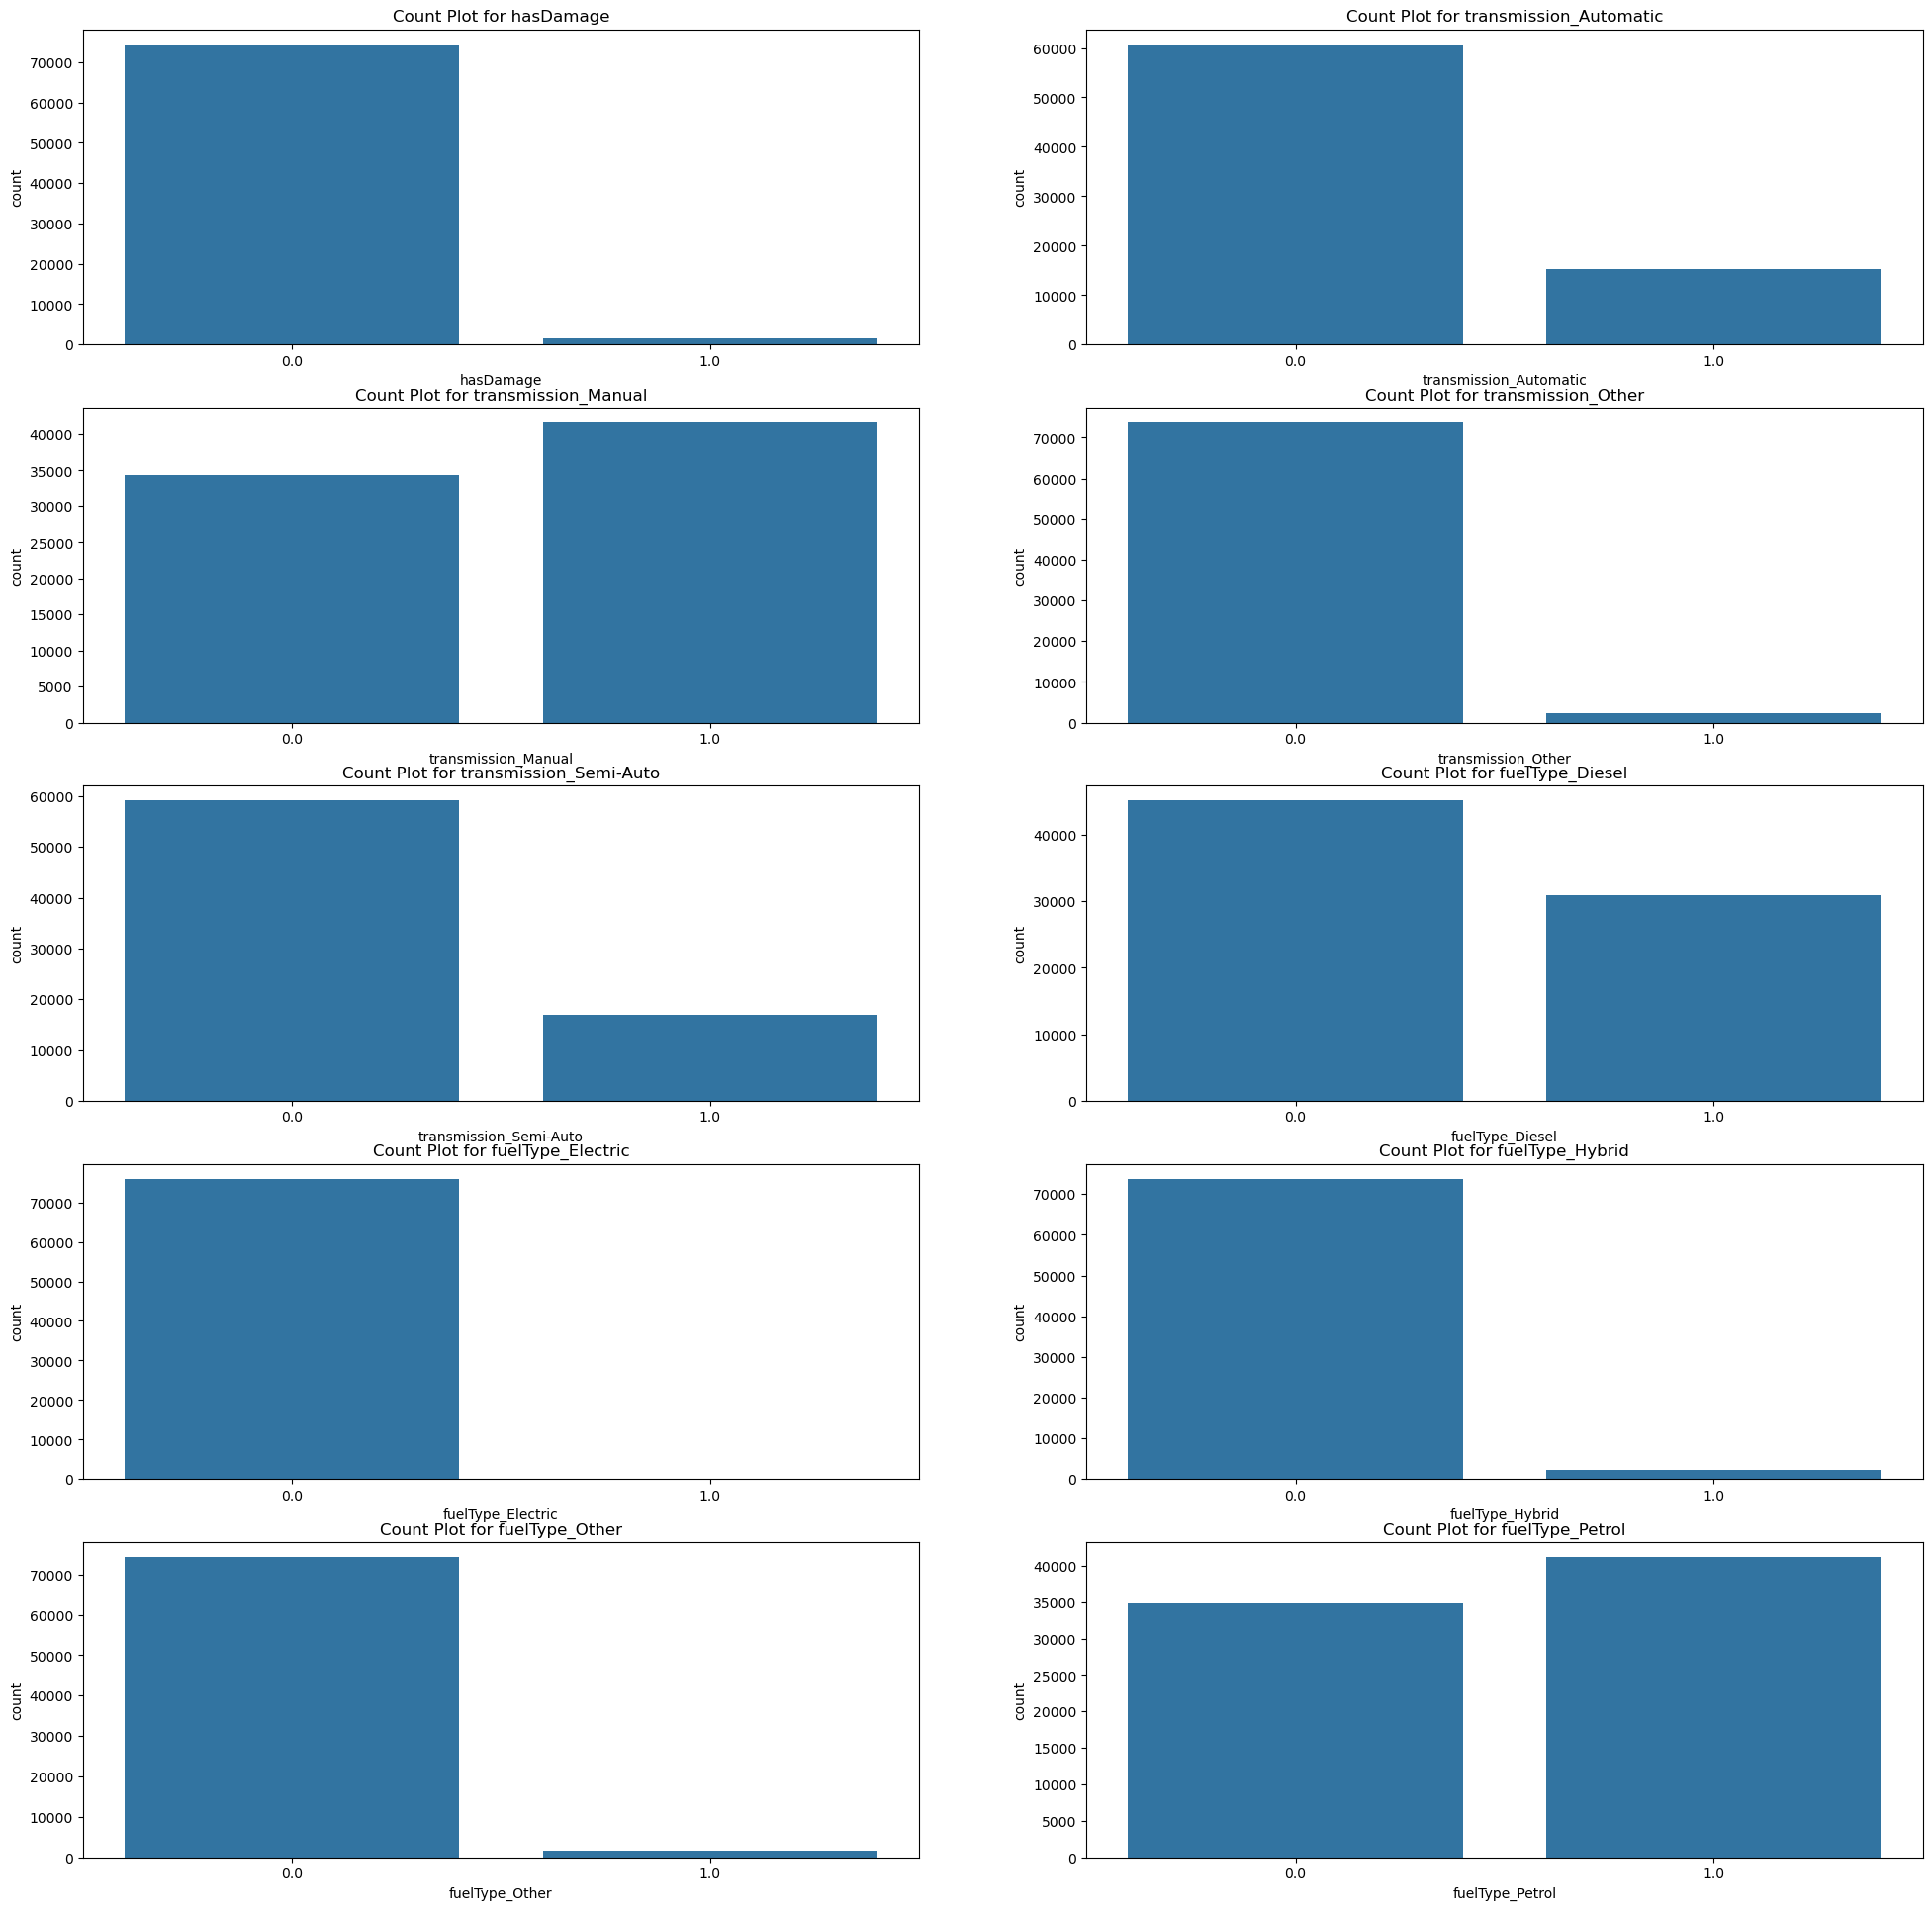

In [13]:
n_features = len(boolean_features)
n_plots_per_row = 2
n_rows = int((n_features) / n_plots_per_row)
fig, axes = plt.subplots(n_rows, n_plots_per_row, figsize=(24, 24))
axes = axes.flatten()
for i, feature in enumerate(boolean_features):
    sns.countplot(x=X_train[feature], ax=axes[i])
    axes[i].set_title(f"Count Plot for {feature}")
    print("-"*50)
    print(f"--- ANALYZING BOOLEAN FEATURE: {feature} ---")
    print("-"*50)
    value_counts = X_train[feature].value_counts()
    print(f"Value counts for {feature}:\n{value_counts}\n")
